In [1]:
!nvidia-smi

Sun Sep  1 18:22:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0               15W /  N/A|      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import rasterio
import numpy as np

path = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\train\msi\0.tiff"
with rasterio.open(path) as src:
    img_msi = src.read()

path = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\train\sar\0.tiff"
with rasterio.open(path) as src:
    img_sar = src.read()


img_combined = np.concatenate((img_msi, img_sar), axis=0)
img_combined.shape

c:\Users\Zeynep\anaconda3\envs\env_torch\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(6, 128, 128)

In [4]:
import os
msi_paths = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\train\msi"
sar_paths = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\train\sar"
mask_paths = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\train\label"

In [8]:
# create a pytorch dataset that concats the msi and sar images
import torch
from torch.utils.data import Dataset

class CombinedDataset(Dataset):
    def __init__(self, msi_paths, sar_paths):
        self.msi_paths = msi_paths
        self.sar_paths = sar_paths

    def __len__(self):
        return len(self.msi_paths)

    def __getitem__(self, idx):
        with rasterio.open(self.msi_paths[idx]) as src:
            img_msi = src.read()

        with rasterio.open(self.sar_paths[idx]) as src:
            img_sar = src.read()

        img_combined = np.concatenate((img_msi, img_sar), axis=0)
        return torch.tensor(img_combined)


In [6]:
num_channels = img_combined.shape[0]
num_channels

6

In [7]:
num_channels, height, width = img_combined.shape
total_data = num_channels * height * width
total_data

98304

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
import segmentation_models_pytorch as smp
import torchmetrics
from tqdm import tqdm

# CombinedDataset sınıfı
class CombinedDataset(Dataset):
    def __init__(self, msi_dir, sar_dir, mask_dir):
        # TODO: check for only .tif or .tiff files
        self.msi_paths = sorted([os.path.join(msi_dir, file) for file in os.listdir(msi_dir)])
        self.sar_paths = sorted([os.path.join(sar_dir, file) for file in os.listdir(sar_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.msi_paths)

    def __getitem__(self, idx):
        with rasterio.open(self.msi_paths[idx]) as src:
            img_msi = src.read()

        with rasterio.open(self.sar_paths[idx]) as src:
            img_sar = src.read()

        with rasterio.open(self.mask_paths[idx]) as src:
            mask = src.read(1)  # Tek bir kanal içerdiği için 1. bandı oku

        img_combined = np.concatenate((img_msi, img_sar), axis=0)
        img_combined = torch.tensor(img_combined, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)

        return img_combined, mask


In [9]:
# Dataset ve DataLoader
train_msi_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\train\msi"
train_sar_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\train\sar"
train_mask_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\train\label"
val_msi_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\val\msi"
val_sar_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\val\sar"
val_mask_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\val\label"

BATCH_SIZE = 16

train_dataset = CombinedDataset(train_msi_dir, train_sar_dir, train_mask_dir)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = CombinedDataset(val_msi_dir, val_sar_dir, val_mask_dir)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
# Modeli tanımlayın
model = smp.UnetPlusPlus(encoder_name="resnet50", in_channels=6, classes=14).to(device)

In [11]:
import datetime
# Kayıp fonksiyonu ve optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Metrik hesaplayıcılar
metrics = {
    "f1": torchmetrics.F1Score(num_classes=14, average='macro', task='multiclass'),
    "iou": torchmetrics.JaccardIndex(num_classes=14, average='macro', task='multiclass'),
    "precision": torchmetrics.Precision(num_classes=14, average='macro', task='multiclass'),
    "recall": torchmetrics.Recall(num_classes=14, average='macro', task='multiclass')
}

# En iyi modeli kaydetme için değişkenler
best_model_path = f"unet++-resnt50-CE-adam-lr1e3-bs16-{datetime.datetime.now().strftime('%Y-%m-%d')}.pt"
best_model_path

'unet++-resnt50-CE-adam-lr1e3-bs16-2024-09-01.pt'

In [12]:

best_f1_score = 0
# Eğitim döngüsü
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    # Eğitim adımı
    for imgs, masks in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(imgs.to(device))
        loss = criterion(outputs, masks.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dataloader)
    
    # Doğrulama adımı
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_dataloader:
            outputs = model(imgs.to(device))
            loss = criterion(outputs, masks.to(device))
            val_loss += loss.item()

            # Prediksiyon ve etiketleri toplama
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = masks.cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

            # Metrikleri hesapla
            metrics["f1"].update(torch.tensor(preds, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64))
            metrics["iou"].update(torch.tensor(preds, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64))
            metrics["precision"].update(torch.tensor(preds, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64))
            metrics["recall"].update(torch.tensor(preds, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64))

    avg_val_loss = val_loss / len(val_dataloader)
    f1 = metrics["f1"].compute().item()
    iou = metrics["iou"].compute().item()
    precision = metrics["precision"].compute().item()
    recall = metrics["recall"].compute().item()

    # En iyi modeli kaydet
    if f1 > best_f1_score:
        best_f1_score = f1
        torch.save(model, best_model_path)
        print(f"Saved best model with F1 Score: {f1:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, F1 Score: {f1:.4f}, IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Metrikleri sıfırla
    for metric in metrics.values():
        metric.reset()

print(f"Training complete. Best model saved to {best_model_path}")


  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\Zeynep\anaconda3\envs\env_torch\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Saved best model with F1 Score: 0.0624
Epoch 1/1000, Train Loss: 2.1649, Val Loss: 2.7509, F1 Score: 0.0624, IoU: 0.0347, Precision: 0.1263, Recall: 0.1191


100%|██████████| 12/12 [00:04<00:00,  2.98it/s]


Saved best model with F1 Score: 0.2276
Epoch 2/1000, Train Loss: 1.4783, Val Loss: 1.5590, F1 Score: 0.2276, IoU: 0.1603, Precision: 0.2877, Recall: 0.2497


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Saved best model with F1 Score: 0.2760
Epoch 3/1000, Train Loss: 1.2633, Val Loss: 1.2623, F1 Score: 0.2760, IoU: 0.2016, Precision: 0.2869, Recall: 0.2962


100%|██████████| 12/12 [00:04<00:00,  2.97it/s]


Epoch 4/1000, Train Loss: 1.1038, Val Loss: 1.3278, F1 Score: 0.2741, IoU: 0.1961, Precision: 0.3197, Recall: 0.2903


100%|██████████| 12/12 [00:04<00:00,  2.98it/s]


Saved best model with F1 Score: 0.3259
Epoch 5/1000, Train Loss: 1.0612, Val Loss: 1.1482, F1 Score: 0.3259, IoU: 0.2471, Precision: 0.3490, Recall: 0.3388


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 6/1000, Train Loss: 0.9714, Val Loss: 1.1351, F1 Score: 0.3211, IoU: 0.2395, Precision: 0.3392, Recall: 0.3407


100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


Saved best model with F1 Score: 0.3478
Epoch 7/1000, Train Loss: 0.9401, Val Loss: 1.0126, F1 Score: 0.3478, IoU: 0.2651, Precision: 0.4238, Recall: 0.3582


100%|██████████| 12/12 [00:04<00:00,  2.95it/s]


Saved best model with F1 Score: 0.3712
Epoch 8/1000, Train Loss: 0.8879, Val Loss: 0.9964, F1 Score: 0.3712, IoU: 0.2840, Precision: 0.4567, Recall: 0.3754


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 9/1000, Train Loss: 0.8603, Val Loss: 1.0719, F1 Score: 0.3690, IoU: 0.2712, Precision: 0.4528, Recall: 0.3578


100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


Saved best model with F1 Score: 0.3912
Epoch 10/1000, Train Loss: 0.8393, Val Loss: 0.9630, F1 Score: 0.3912, IoU: 0.2967, Precision: 0.4247, Recall: 0.4049


100%|██████████| 12/12 [00:04<00:00,  2.94it/s]


Saved best model with F1 Score: 0.4003
Epoch 11/1000, Train Loss: 0.7742, Val Loss: 1.0289, F1 Score: 0.4003, IoU: 0.2998, Precision: 0.4495, Recall: 0.4009


100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Saved best model with F1 Score: 0.4206
Epoch 12/1000, Train Loss: 0.7475, Val Loss: 1.0351, F1 Score: 0.4206, IoU: 0.3116, Precision: 0.5515, Recall: 0.3923


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.4680
Epoch 13/1000, Train Loss: 0.7012, Val Loss: 0.9014, F1 Score: 0.4680, IoU: 0.3564, Precision: 0.5087, Recall: 0.4867


100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


Saved best model with F1 Score: 0.5146
Epoch 14/1000, Train Loss: 0.6564, Val Loss: 0.8113, F1 Score: 0.5146, IoU: 0.4078, Precision: 0.5716, Recall: 0.4973


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.5236
Epoch 15/1000, Train Loss: 0.6430, Val Loss: 0.7800, F1 Score: 0.5236, IoU: 0.4178, Precision: 0.5736, Recall: 0.5102


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.5358
Epoch 16/1000, Train Loss: 0.6064, Val Loss: 0.7839, F1 Score: 0.5358, IoU: 0.4314, Precision: 0.5790, Recall: 0.5227


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.5455
Epoch 17/1000, Train Loss: 0.5776, Val Loss: 0.7379, F1 Score: 0.5455, IoU: 0.4421, Precision: 0.5905, Recall: 0.5336


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Saved best model with F1 Score: 0.5629
Epoch 18/1000, Train Loss: 0.5673, Val Loss: 0.7352, F1 Score: 0.5629, IoU: 0.4568, Precision: 0.5917, Recall: 0.5503


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Saved best model with F1 Score: 0.5639
Epoch 19/1000, Train Loss: 0.5611, Val Loss: 0.7179, F1 Score: 0.5639, IoU: 0.4593, Precision: 0.5721, Recall: 0.5727


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Saved best model with F1 Score: 0.5718
Epoch 20/1000, Train Loss: 0.5253, Val Loss: 0.6810, F1 Score: 0.5718, IoU: 0.4688, Precision: 0.6142, Recall: 0.5542


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.5837
Epoch 21/1000, Train Loss: 0.4925, Val Loss: 0.6510, F1 Score: 0.5837, IoU: 0.4815, Precision: 0.6062, Recall: 0.5765


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.5852
Epoch 22/1000, Train Loss: 0.4757, Val Loss: 0.6478, F1 Score: 0.5852, IoU: 0.4847, Precision: 0.6110, Recall: 0.5819


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.5983
Epoch 23/1000, Train Loss: 0.4527, Val Loss: 0.6186, F1 Score: 0.5983, IoU: 0.5001, Precision: 0.6146, Recall: 0.5965


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 24/1000, Train Loss: 0.4396, Val Loss: 0.6509, F1 Score: 0.5902, IoU: 0.4863, Precision: 0.6263, Recall: 0.5729


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Saved best model with F1 Score: 0.5993
Epoch 25/1000, Train Loss: 0.4259, Val Loss: 0.6229, F1 Score: 0.5993, IoU: 0.5009, Precision: 0.6215, Recall: 0.5954


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Saved best model with F1 Score: 0.6132
Epoch 26/1000, Train Loss: 0.4140, Val Loss: 0.5748, F1 Score: 0.6132, IoU: 0.5143, Precision: 0.6306, Recall: 0.6036


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.6160
Epoch 27/1000, Train Loss: 0.3894, Val Loss: 0.5594, F1 Score: 0.6160, IoU: 0.5193, Precision: 0.6237, Recall: 0.6168


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Saved best model with F1 Score: 0.6304
Epoch 28/1000, Train Loss: 0.3641, Val Loss: 0.5475, F1 Score: 0.6304, IoU: 0.5341, Precision: 0.6469, Recall: 0.6193


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.6329
Epoch 29/1000, Train Loss: 0.3482, Val Loss: 0.5188, F1 Score: 0.6329, IoU: 0.5376, Precision: 0.6476, Recall: 0.6209


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.6348
Epoch 30/1000, Train Loss: 0.3282, Val Loss: 0.5231, F1 Score: 0.6348, IoU: 0.5393, Precision: 0.6484, Recall: 0.6248


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 31/1000, Train Loss: 0.3233, Val Loss: 0.5349, F1 Score: 0.6261, IoU: 0.5267, Precision: 0.6199, Recall: 0.6353


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Saved best model with F1 Score: 0.6395
Epoch 32/1000, Train Loss: 0.3079, Val Loss: 0.5069, F1 Score: 0.6395, IoU: 0.5461, Precision: 0.6600, Recall: 0.6246


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.6412
Epoch 33/1000, Train Loss: 0.2962, Val Loss: 0.5016, F1 Score: 0.6412, IoU: 0.5474, Precision: 0.6499, Recall: 0.6381


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Saved best model with F1 Score: 0.6492
Epoch 34/1000, Train Loss: 0.2800, Val Loss: 0.4765, F1 Score: 0.6492, IoU: 0.5584, Precision: 0.6688, Recall: 0.6341


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.6572
Epoch 35/1000, Train Loss: 0.2624, Val Loss: 0.4455, F1 Score: 0.6572, IoU: 0.5690, Precision: 0.6753, Recall: 0.6425


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Saved best model with F1 Score: 0.6594
Epoch 36/1000, Train Loss: 0.2511, Val Loss: 0.4410, F1 Score: 0.6594, IoU: 0.5721, Precision: 0.6714, Recall: 0.6509


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Saved best model with F1 Score: 0.6618
Epoch 37/1000, Train Loss: 0.2369, Val Loss: 0.4387, F1 Score: 0.6618, IoU: 0.5750, Precision: 0.7525, Recall: 0.6464


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.6673
Epoch 38/1000, Train Loss: 0.2222, Val Loss: 0.4265, F1 Score: 0.6673, IoU: 0.5835, Precision: 0.7533, Recall: 0.6549


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Saved best model with F1 Score: 0.6728
Epoch 39/1000, Train Loss: 0.2098, Val Loss: 0.4041, F1 Score: 0.6728, IoU: 0.5914, Precision: 0.6792, Recall: 0.6677


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 40/1000, Train Loss: 0.2053, Val Loss: 0.4146, F1 Score: 0.6684, IoU: 0.5837, Precision: 0.7542, Recall: 0.6560


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.6753
Epoch 41/1000, Train Loss: 0.2000, Val Loss: 0.3988, F1 Score: 0.6753, IoU: 0.5927, Precision: 0.8250, Recall: 0.6678


100%|██████████| 12/12 [00:04<00:00,  2.94it/s]


Saved best model with F1 Score: 0.6815
Epoch 42/1000, Train Loss: 0.1876, Val Loss: 0.3942, F1 Score: 0.6815, IoU: 0.5972, Precision: 0.8250, Recall: 0.6695


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.7009
Epoch 43/1000, Train Loss: 0.1802, Val Loss: 0.3958, F1 Score: 0.7009, IoU: 0.6134, Precision: 0.8988, Recall: 0.6809


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 44/1000, Train Loss: 0.1728, Val Loss: 0.3797, F1 Score: 0.6993, IoU: 0.6117, Precision: 0.8871, Recall: 0.6912


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.7490
Epoch 45/1000, Train Loss: 0.1598, Val Loss: 0.3749, F1 Score: 0.7490, IoU: 0.6491, Precision: 0.8865, Recall: 0.7246


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Saved best model with F1 Score: 0.7957
Epoch 46/1000, Train Loss: 0.1567, Val Loss: 0.3788, F1 Score: 0.7957, IoU: 0.6858, Precision: 0.9042, Recall: 0.7524


100%|██████████| 12/12 [00:04<00:00,  2.95it/s]


Saved best model with F1 Score: 0.8120
Epoch 47/1000, Train Loss: 0.1508, Val Loss: 0.3872, F1 Score: 0.8120, IoU: 0.7026, Precision: 0.9015, Recall: 0.7693


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Saved best model with F1 Score: 0.8323
Epoch 48/1000, Train Loss: 0.1455, Val Loss: 0.3647, F1 Score: 0.8323, IoU: 0.7270, Precision: 0.8995, Recall: 0.7976


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.8453
Epoch 49/1000, Train Loss: 0.1411, Val Loss: 0.3594, F1 Score: 0.8453, IoU: 0.7415, Precision: 0.9069, Recall: 0.8078


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Saved best model with F1 Score: 0.8460
Epoch 50/1000, Train Loss: 0.1361, Val Loss: 0.3684, F1 Score: 0.8460, IoU: 0.7398, Precision: 0.8810, Recall: 0.8226


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.8542
Epoch 51/1000, Train Loss: 0.1290, Val Loss: 0.3417, F1 Score: 0.8542, IoU: 0.7537, Precision: 0.8946, Recall: 0.8289


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 52/1000, Train Loss: 0.1276, Val Loss: 0.3586, F1 Score: 0.8515, IoU: 0.7495, Precision: 0.9010, Recall: 0.8206


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 53/1000, Train Loss: 0.1318, Val Loss: 0.3642, F1 Score: 0.8412, IoU: 0.7376, Precision: 0.8926, Recall: 0.8130


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 54/1000, Train Loss: 0.1267, Val Loss: 0.3861, F1 Score: 0.8513, IoU: 0.7470, Precision: 0.8951, Recall: 0.8174


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 55/1000, Train Loss: 0.1267, Val Loss: 0.3970, F1 Score: 0.8464, IoU: 0.7395, Precision: 0.8815, Recall: 0.8251


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.8604
Epoch 56/1000, Train Loss: 0.1212, Val Loss: 0.3452, F1 Score: 0.8604, IoU: 0.7606, Precision: 0.9000, Recall: 0.8305


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.8683
Epoch 57/1000, Train Loss: 0.1138, Val Loss: 0.3413, F1 Score: 0.8683, IoU: 0.7711, Precision: 0.8998, Recall: 0.8432


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 58/1000, Train Loss: 0.1136, Val Loss: 0.3725, F1 Score: 0.8562, IoU: 0.7536, Precision: 0.8764, Recall: 0.8412


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 59/1000, Train Loss: 0.1184, Val Loss: 0.3718, F1 Score: 0.8517, IoU: 0.7493, Precision: 0.8914, Recall: 0.8285


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.8684
Epoch 60/1000, Train Loss: 0.1125, Val Loss: 0.3423, F1 Score: 0.8684, IoU: 0.7719, Precision: 0.9024, Recall: 0.8416


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.8758
Epoch 61/1000, Train Loss: 0.1017, Val Loss: 0.3316, F1 Score: 0.8758, IoU: 0.7831, Precision: 0.9009, Recall: 0.8549


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 62/1000, Train Loss: 0.0979, Val Loss: 0.3393, F1 Score: 0.8745, IoU: 0.7815, Precision: 0.9207, Recall: 0.8396


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Saved best model with F1 Score: 0.8820
Epoch 63/1000, Train Loss: 0.0915, Val Loss: 0.3229, F1 Score: 0.8820, IoU: 0.7923, Precision: 0.9113, Recall: 0.8583


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 64/1000, Train Loss: 0.0865, Val Loss: 0.3359, F1 Score: 0.8792, IoU: 0.7879, Precision: 0.9089, Recall: 0.8553


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Saved best model with F1 Score: 0.8845
Epoch 65/1000, Train Loss: 0.0813, Val Loss: 0.3170, F1 Score: 0.8845, IoU: 0.7959, Precision: 0.9201, Recall: 0.8553


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 66/1000, Train Loss: 0.0809, Val Loss: 0.3346, F1 Score: 0.8835, IoU: 0.7949, Precision: 0.9174, Recall: 0.8568


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 67/1000, Train Loss: 0.0809, Val Loss: 0.3378, F1 Score: 0.8811, IoU: 0.7908, Precision: 0.9088, Recall: 0.8598


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.8884
Epoch 68/1000, Train Loss: 0.0787, Val Loss: 0.3234, F1 Score: 0.8884, IoU: 0.8021, Precision: 0.9150, Recall: 0.8664


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 69/1000, Train Loss: 0.0764, Val Loss: 0.3352, F1 Score: 0.8818, IoU: 0.7918, Precision: 0.9162, Recall: 0.8547


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.8888
Epoch 70/1000, Train Loss: 0.0764, Val Loss: 0.3208, F1 Score: 0.8888, IoU: 0.8028, Precision: 0.9080, Recall: 0.8733


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 71/1000, Train Loss: 0.0735, Val Loss: 0.3377, F1 Score: 0.8848, IoU: 0.7965, Precision: 0.9134, Recall: 0.8610


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Saved best model with F1 Score: 0.8903
Epoch 72/1000, Train Loss: 0.0746, Val Loss: 0.3263, F1 Score: 0.8903, IoU: 0.8047, Precision: 0.9158, Recall: 0.8693


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Saved best model with F1 Score: 0.8925
Epoch 73/1000, Train Loss: 0.0713, Val Loss: 0.3158, F1 Score: 0.8925, IoU: 0.8083, Precision: 0.9115, Recall: 0.8768


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 74/1000, Train Loss: 0.0718, Val Loss: 0.3327, F1 Score: 0.8906, IoU: 0.8052, Precision: 0.9095, Recall: 0.8748


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 75/1000, Train Loss: 0.0723, Val Loss: 0.3273, F1 Score: 0.8922, IoU: 0.8078, Precision: 0.9066, Recall: 0.8793


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 76/1000, Train Loss: 0.0712, Val Loss: 0.3140, F1 Score: 0.8870, IoU: 0.8009, Precision: 0.9140, Recall: 0.8656


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Saved best model with F1 Score: 0.8925
Epoch 77/1000, Train Loss: 0.0669, Val Loss: 0.3234, F1 Score: 0.8925, IoU: 0.8084, Precision: 0.9145, Recall: 0.8735


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.8948
Epoch 78/1000, Train Loss: 0.0638, Val Loss: 0.3172, F1 Score: 0.8948, IoU: 0.8117, Precision: 0.9150, Recall: 0.8776


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 79/1000, Train Loss: 0.0630, Val Loss: 0.3299, F1 Score: 0.8930, IoU: 0.8092, Precision: 0.9186, Recall: 0.8726


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.8964
Epoch 80/1000, Train Loss: 0.0617, Val Loss: 0.3125, F1 Score: 0.8964, IoU: 0.8147, Precision: 0.9229, Recall: 0.8744


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 81/1000, Train Loss: 0.0612, Val Loss: 0.3323, F1 Score: 0.8920, IoU: 0.8075, Precision: 0.9201, Recall: 0.8693


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.8969
Epoch 82/1000, Train Loss: 0.0579, Val Loss: 0.3114, F1 Score: 0.8969, IoU: 0.8154, Precision: 0.9197, Recall: 0.8777


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.8974
Epoch 83/1000, Train Loss: 0.0560, Val Loss: 0.3248, F1 Score: 0.8974, IoU: 0.8161, Precision: 0.9187, Recall: 0.8798


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.9032
Epoch 84/1000, Train Loss: 0.0529, Val Loss: 0.3197, F1 Score: 0.9032, IoU: 0.8255, Precision: 0.9282, Recall: 0.8823


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 85/1000, Train Loss: 0.0509, Val Loss: 0.3193, F1 Score: 0.8973, IoU: 0.8164, Precision: 0.9171, Recall: 0.8804


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 86/1000, Train Loss: 0.0498, Val Loss: 0.3223, F1 Score: 0.9032, IoU: 0.8251, Precision: 0.9302, Recall: 0.8802


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 87/1000, Train Loss: 0.0529, Val Loss: 0.3412, F1 Score: 0.9009, IoU: 0.8214, Precision: 0.9254, Recall: 0.8804


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 88/1000, Train Loss: 0.0529, Val Loss: 0.3324, F1 Score: 0.8978, IoU: 0.8167, Precision: 0.9196, Recall: 0.8800


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 89/1000, Train Loss: 0.0522, Val Loss: 0.3317, F1 Score: 0.8968, IoU: 0.8154, Precision: 0.9273, Recall: 0.8715


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 90/1000, Train Loss: 0.0542, Val Loss: 0.3247, F1 Score: 0.8927, IoU: 0.8103, Precision: 0.9251, Recall: 0.8697


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 91/1000, Train Loss: 0.0524, Val Loss: 0.3316, F1 Score: 0.9010, IoU: 0.8216, Precision: 0.9142, Recall: 0.8903


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 92/1000, Train Loss: 0.0503, Val Loss: 0.3302, F1 Score: 0.9025, IoU: 0.8241, Precision: 0.9166, Recall: 0.8908


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.9089
Epoch 93/1000, Train Loss: 0.0471, Val Loss: 0.3212, F1 Score: 0.9089, IoU: 0.8344, Precision: 0.9251, Recall: 0.8947


100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


Epoch 94/1000, Train Loss: 0.0452, Val Loss: 0.3291, F1 Score: 0.9070, IoU: 0.8315, Precision: 0.9317, Recall: 0.8856


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 95/1000, Train Loss: 0.0453, Val Loss: 0.3170, F1 Score: 0.9072, IoU: 0.8316, Precision: 0.9254, Recall: 0.8920


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 96/1000, Train Loss: 0.0450, Val Loss: 0.3251, F1 Score: 0.9054, IoU: 0.8286, Precision: 0.9267, Recall: 0.8874


100%|██████████| 12/12 [00:04<00:00,  2.95it/s]


Epoch 97/1000, Train Loss: 0.0417, Val Loss: 0.3250, F1 Score: 0.9084, IoU: 0.8337, Precision: 0.9290, Recall: 0.8903


100%|██████████| 12/12 [00:04<00:00,  2.94it/s]


Epoch 98/1000, Train Loss: 0.0497, Val Loss: 0.3422, F1 Score: 0.8985, IoU: 0.8177, Precision: 0.9115, Recall: 0.8865


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 99/1000, Train Loss: 0.0678, Val Loss: 0.4455, F1 Score: 0.8682, IoU: 0.7706, Precision: 0.8966, Recall: 0.8453


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 100/1000, Train Loss: 0.0800, Val Loss: 0.4307, F1 Score: 0.8622, IoU: 0.7625, Precision: 0.8853, Recall: 0.8471


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 101/1000, Train Loss: 0.1045, Val Loss: 1.3865, F1 Score: 0.5833, IoU: 0.4528, Precision: 0.6913, Recall: 0.5930


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 102/1000, Train Loss: 0.1835, Val Loss: 0.7823, F1 Score: 0.7172, IoU: 0.5830, Precision: 0.8061, Recall: 0.6812


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 103/1000, Train Loss: 0.2491, Val Loss: 0.9376, F1 Score: 0.7143, IoU: 0.5672, Precision: 0.7086, Recall: 0.7343


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 104/1000, Train Loss: 0.2397, Val Loss: 0.7968, F1 Score: 0.7528, IoU: 0.6124, Precision: 0.7764, Recall: 0.7525


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 105/1000, Train Loss: 0.2066, Val Loss: 0.5883, F1 Score: 0.8040, IoU: 0.6780, Precision: 0.8145, Recall: 0.8027


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 106/1000, Train Loss: 0.1573, Val Loss: 0.3929, F1 Score: 0.8363, IoU: 0.7249, Precision: 0.8815, Recall: 0.8020


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 107/1000, Train Loss: 0.1323, Val Loss: 0.3943, F1 Score: 0.8558, IoU: 0.7515, Precision: 0.8757, Recall: 0.8432


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 108/1000, Train Loss: 0.1012, Val Loss: 0.3292, F1 Score: 0.8762, IoU: 0.7834, Precision: 0.8920, Recall: 0.8647


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 109/1000, Train Loss: 0.0824, Val Loss: 0.3108, F1 Score: 0.8896, IoU: 0.8042, Precision: 0.9175, Recall: 0.8670


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 110/1000, Train Loss: 0.0707, Val Loss: 0.3030, F1 Score: 0.8989, IoU: 0.8185, Precision: 0.9212, Recall: 0.8794


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 111/1000, Train Loss: 0.0621, Val Loss: 0.2941, F1 Score: 0.9010, IoU: 0.8220, Precision: 0.9277, Recall: 0.8782


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 112/1000, Train Loss: 0.0560, Val Loss: 0.3058, F1 Score: 0.9050, IoU: 0.8283, Precision: 0.9235, Recall: 0.8889


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 113/1000, Train Loss: 0.0495, Val Loss: 0.3066, F1 Score: 0.9048, IoU: 0.8280, Precision: 0.9279, Recall: 0.8847


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.9095
Epoch 114/1000, Train Loss: 0.0522, Val Loss: 0.2943, F1 Score: 0.9095, IoU: 0.8358, Precision: 0.9221, Recall: 0.8981


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Saved best model with F1 Score: 0.9122
Epoch 115/1000, Train Loss: 0.0465, Val Loss: 0.2962, F1 Score: 0.9122, IoU: 0.8401, Precision: 0.9287, Recall: 0.8978


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Saved best model with F1 Score: 0.9139
Epoch 116/1000, Train Loss: 0.0439, Val Loss: 0.2903, F1 Score: 0.9139, IoU: 0.8429, Precision: 0.9351, Recall: 0.8956


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Saved best model with F1 Score: 0.9150
Epoch 117/1000, Train Loss: 0.0413, Val Loss: 0.2882, F1 Score: 0.9150, IoU: 0.8449, Precision: 0.9290, Recall: 0.9031


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 118/1000, Train Loss: 0.0391, Val Loss: 0.2936, F1 Score: 0.9135, IoU: 0.8423, Precision: 0.9241, Recall: 0.9044


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 119/1000, Train Loss: 0.0380, Val Loss: 0.2889, F1 Score: 0.9144, IoU: 0.8438, Precision: 0.9352, Recall: 0.8958


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Saved best model with F1 Score: 0.9207
Epoch 120/1000, Train Loss: 0.0346, Val Loss: 0.2911, F1 Score: 0.9207, IoU: 0.8541, Precision: 0.9386, Recall: 0.9046


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 121/1000, Train Loss: 0.0328, Val Loss: 0.2982, F1 Score: 0.9190, IoU: 0.8513, Precision: 0.9378, Recall: 0.9026


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 122/1000, Train Loss: 0.0330, Val Loss: 0.3059, F1 Score: 0.9195, IoU: 0.8521, Precision: 0.9336, Recall: 0.9068


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 123/1000, Train Loss: 0.0319, Val Loss: 0.2926, F1 Score: 0.9197, IoU: 0.8526, Precision: 0.9344, Recall: 0.9069


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Saved best model with F1 Score: 0.9216
Epoch 124/1000, Train Loss: 0.0321, Val Loss: 0.2986, F1 Score: 0.9216, IoU: 0.8557, Precision: 0.9421, Recall: 0.9035


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Saved best model with F1 Score: 0.9228
Epoch 125/1000, Train Loss: 0.0310, Val Loss: 0.2961, F1 Score: 0.9228, IoU: 0.8577, Precision: 0.9370, Recall: 0.9098


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Saved best model with F1 Score: 0.9249
Epoch 126/1000, Train Loss: 0.0294, Val Loss: 0.2927, F1 Score: 0.9249, IoU: 0.8613, Precision: 0.9422, Recall: 0.9092


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Saved best model with F1 Score: 0.9251
Epoch 127/1000, Train Loss: 0.0287, Val Loss: 0.2958, F1 Score: 0.9251, IoU: 0.8616, Precision: 0.9362, Recall: 0.9150


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.9259
Epoch 128/1000, Train Loss: 0.0287, Val Loss: 0.2913, F1 Score: 0.9259, IoU: 0.8631, Precision: 0.9380, Recall: 0.9150


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 129/1000, Train Loss: 0.0275, Val Loss: 0.3010, F1 Score: 0.9255, IoU: 0.8622, Precision: 0.9366, Recall: 0.9155


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Saved best model with F1 Score: 0.9267
Epoch 130/1000, Train Loss: 0.0261, Val Loss: 0.2988, F1 Score: 0.9267, IoU: 0.8644, Precision: 0.9394, Recall: 0.9152


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 131/1000, Train Loss: 0.0270, Val Loss: 0.3087, F1 Score: 0.9226, IoU: 0.8575, Precision: 0.9348, Recall: 0.9117


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 132/1000, Train Loss: 0.0288, Val Loss: 0.2984, F1 Score: 0.9230, IoU: 0.8581, Precision: 0.9392, Recall: 0.9089


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 133/1000, Train Loss: 0.0261, Val Loss: 0.3080, F1 Score: 0.9252, IoU: 0.8620, Precision: 0.9421, Recall: 0.9104


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 134/1000, Train Loss: 0.0266, Val Loss: 0.3078, F1 Score: 0.9234, IoU: 0.8587, Precision: 0.9384, Recall: 0.9104


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Epoch 135/1000, Train Loss: 0.0265, Val Loss: 0.3061, F1 Score: 0.9257, IoU: 0.8627, Precision: 0.9410, Recall: 0.9123


100%|██████████| 12/12 [00:04<00:00,  2.94it/s]


Saved best model with F1 Score: 0.9271
Epoch 136/1000, Train Loss: 0.0269, Val Loss: 0.2979, F1 Score: 0.9271, IoU: 0.8651, Precision: 0.9410, Recall: 0.9149


100%|██████████| 12/12 [00:04<00:00,  2.94it/s]


Epoch 137/1000, Train Loss: 0.0253, Val Loss: 0.3052, F1 Score: 0.9268, IoU: 0.8646, Precision: 0.9407, Recall: 0.9143


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Saved best model with F1 Score: 0.9282
Epoch 138/1000, Train Loss: 0.0244, Val Loss: 0.3056, F1 Score: 0.9282, IoU: 0.8669, Precision: 0.9461, Recall: 0.9119


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 139/1000, Train Loss: 0.0235, Val Loss: 0.3067, F1 Score: 0.9239, IoU: 0.8597, Precision: 0.9358, Recall: 0.9139


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Saved best model with F1 Score: 0.9292
Epoch 140/1000, Train Loss: 0.0222, Val Loss: 0.3039, F1 Score: 0.9292, IoU: 0.8688, Precision: 0.9426, Recall: 0.9172


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 141/1000, Train Loss: 0.0217, Val Loss: 0.3035, F1 Score: 0.9278, IoU: 0.8663, Precision: 0.9483, Recall: 0.9094


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 142/1000, Train Loss: 0.0230, Val Loss: 0.3116, F1 Score: 0.9263, IoU: 0.8637, Precision: 0.9389, Recall: 0.9149


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 143/1000, Train Loss: 0.0214, Val Loss: 0.3048, F1 Score: 0.9278, IoU: 0.8663, Precision: 0.9441, Recall: 0.9131


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 144/1000, Train Loss: 0.0210, Val Loss: 0.3123, F1 Score: 0.9271, IoU: 0.8650, Precision: 0.9365, Recall: 0.9192


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Saved best model with F1 Score: 0.9314
Epoch 145/1000, Train Loss: 0.0195, Val Loss: 0.3077, F1 Score: 0.9314, IoU: 0.8725, Precision: 0.9446, Recall: 0.9192


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 146/1000, Train Loss: 0.0194, Val Loss: 0.3119, F1 Score: 0.9302, IoU: 0.8704, Precision: 0.9485, Recall: 0.9139


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 147/1000, Train Loss: 0.0195, Val Loss: 0.3076, F1 Score: 0.9304, IoU: 0.8709, Precision: 0.9467, Recall: 0.9158


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 148/1000, Train Loss: 0.0183, Val Loss: 0.3116, F1 Score: 0.9280, IoU: 0.8667, Precision: 0.9368, Recall: 0.9208


100%|██████████| 12/12 [00:04<00:00,  2.96it/s]


Epoch 149/1000, Train Loss: 0.0193, Val Loss: 0.3114, F1 Score: 0.9309, IoU: 0.8715, Precision: 0.9484, Recall: 0.9150


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 150/1000, Train Loss: 0.0198, Val Loss: 0.3224, F1 Score: 0.9263, IoU: 0.8637, Precision: 0.9444, Recall: 0.9102


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 151/1000, Train Loss: 0.0192, Val Loss: 0.3196, F1 Score: 0.9266, IoU: 0.8642, Precision: 0.9457, Recall: 0.9093


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 152/1000, Train Loss: 0.0203, Val Loss: 0.3220, F1 Score: 0.9271, IoU: 0.8650, Precision: 0.9423, Recall: 0.9139


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 153/1000, Train Loss: 0.0190, Val Loss: 0.3222, F1 Score: 0.9289, IoU: 0.8682, Precision: 0.9413, Recall: 0.9183


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 154/1000, Train Loss: 0.0189, Val Loss: 0.3080, F1 Score: 0.9309, IoU: 0.8718, Precision: 0.9424, Recall: 0.9204


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 155/1000, Train Loss: 0.0180, Val Loss: 0.3150, F1 Score: 0.9305, IoU: 0.8709, Precision: 0.9435, Recall: 0.9188


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Saved best model with F1 Score: 0.9321
Epoch 156/1000, Train Loss: 0.0177, Val Loss: 0.3097, F1 Score: 0.9321, IoU: 0.8738, Precision: 0.9460, Recall: 0.9197


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 157/1000, Train Loss: 0.0174, Val Loss: 0.3132, F1 Score: 0.9302, IoU: 0.8705, Precision: 0.9403, Recall: 0.9213


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 158/1000, Train Loss: 0.0173, Val Loss: 0.3257, F1 Score: 0.9274, IoU: 0.8656, Precision: 0.9440, Recall: 0.9135


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 159/1000, Train Loss: 0.0172, Val Loss: 0.3155, F1 Score: 0.9306, IoU: 0.8711, Precision: 0.9425, Recall: 0.9200


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 160/1000, Train Loss: 0.0168, Val Loss: 0.3255, F1 Score: 0.9297, IoU: 0.8694, Precision: 0.9410, Recall: 0.9196


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Saved best model with F1 Score: 0.9335
Epoch 161/1000, Train Loss: 0.0169, Val Loss: 0.3144, F1 Score: 0.9335, IoU: 0.8763, Precision: 0.9466, Recall: 0.9221


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 162/1000, Train Loss: 0.0150, Val Loss: 0.3080, F1 Score: 0.9318, IoU: 0.8733, Precision: 0.9379, Recall: 0.9268


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 163/1000, Train Loss: 0.0151, Val Loss: 0.3204, F1 Score: 0.9321, IoU: 0.8737, Precision: 0.9430, Recall: 0.9221


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 164/1000, Train Loss: 0.0156, Val Loss: 0.3271, F1 Score: 0.9301, IoU: 0.8703, Precision: 0.9448, Recall: 0.9169


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 165/1000, Train Loss: 0.0153, Val Loss: 0.3187, F1 Score: 0.9308, IoU: 0.8713, Precision: 0.9395, Recall: 0.9228


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 166/1000, Train Loss: 0.0146, Val Loss: 0.3209, F1 Score: 0.9313, IoU: 0.8724, Precision: 0.9436, Recall: 0.9205


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.9364
Epoch 167/1000, Train Loss: 0.0138, Val Loss: 0.3131, F1 Score: 0.9364, IoU: 0.8812, Precision: 0.9484, Recall: 0.9255


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 168/1000, Train Loss: 0.0133, Val Loss: 0.3169, F1 Score: 0.9356, IoU: 0.8800, Precision: 0.9481, Recall: 0.9243


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 169/1000, Train Loss: 0.0132, Val Loss: 0.3278, F1 Score: 0.9339, IoU: 0.8769, Precision: 0.9462, Recall: 0.9231


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 170/1000, Train Loss: 0.0140, Val Loss: 0.3228, F1 Score: 0.9361, IoU: 0.8807, Precision: 0.9471, Recall: 0.9261


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 171/1000, Train Loss: 0.0144, Val Loss: 0.3229, F1 Score: 0.9325, IoU: 0.8743, Precision: 0.9476, Recall: 0.9186


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 172/1000, Train Loss: 0.0147, Val Loss: 0.3300, F1 Score: 0.9307, IoU: 0.8714, Precision: 0.9459, Recall: 0.9169


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 173/1000, Train Loss: 0.0138, Val Loss: 0.3294, F1 Score: 0.9315, IoU: 0.8728, Precision: 0.9386, Recall: 0.9258


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 174/1000, Train Loss: 0.0129, Val Loss: 0.3136, F1 Score: 0.9354, IoU: 0.8795, Precision: 0.9449, Recall: 0.9267


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 175/1000, Train Loss: 0.0127, Val Loss: 0.3283, F1 Score: 0.9327, IoU: 0.8750, Precision: 0.9411, Recall: 0.9254


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 176/1000, Train Loss: 0.0132, Val Loss: 0.3246, F1 Score: 0.9350, IoU: 0.8787, Precision: 0.9441, Recall: 0.9269


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 177/1000, Train Loss: 0.0129, Val Loss: 0.3265, F1 Score: 0.9334, IoU: 0.8761, Precision: 0.9512, Recall: 0.9176


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 178/1000, Train Loss: 0.0129, Val Loss: 0.3281, F1 Score: 0.9333, IoU: 0.8758, Precision: 0.9482, Recall: 0.9202


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 179/1000, Train Loss: 0.0123, Val Loss: 0.3243, F1 Score: 0.9354, IoU: 0.8796, Precision: 0.9486, Recall: 0.9235


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 180/1000, Train Loss: 0.0115, Val Loss: 0.3255, F1 Score: 0.9357, IoU: 0.8801, Precision: 0.9428, Recall: 0.9295


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 181/1000, Train Loss: 0.0117, Val Loss: 0.3246, F1 Score: 0.9359, IoU: 0.8804, Precision: 0.9457, Recall: 0.9270


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Saved best model with F1 Score: 0.9376
Epoch 182/1000, Train Loss: 0.0110, Val Loss: 0.3302, F1 Score: 0.9376, IoU: 0.8834, Precision: 0.9508, Recall: 0.9257


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.9377
Epoch 183/1000, Train Loss: 0.0108, Val Loss: 0.3274, F1 Score: 0.9377, IoU: 0.8836, Precision: 0.9494, Recall: 0.9273


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.9377
Epoch 184/1000, Train Loss: 0.0110, Val Loss: 0.3227, F1 Score: 0.9377, IoU: 0.8837, Precision: 0.9484, Recall: 0.9282


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.9378
Epoch 185/1000, Train Loss: 0.0105, Val Loss: 0.3234, F1 Score: 0.9378, IoU: 0.8838, Precision: 0.9500, Recall: 0.9267


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 186/1000, Train Loss: 0.0103, Val Loss: 0.3286, F1 Score: 0.9369, IoU: 0.8822, Precision: 0.9477, Recall: 0.9270


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 187/1000, Train Loss: 0.0123, Val Loss: 0.9635, F1 Score: 0.8215, IoU: 0.7007, Precision: 0.9154, Recall: 0.7583


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 188/1000, Train Loss: 0.0206, Val Loss: 0.3916, F1 Score: 0.9121, IoU: 0.8392, Precision: 0.9176, Recall: 0.9080


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 189/1000, Train Loss: 0.0214, Val Loss: 0.3525, F1 Score: 0.9245, IoU: 0.8606, Precision: 0.9379, Recall: 0.9129


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 190/1000, Train Loss: 0.0217, Val Loss: 0.3563, F1 Score: 0.9272, IoU: 0.8652, Precision: 0.9395, Recall: 0.9161


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 191/1000, Train Loss: 0.0213, Val Loss: 0.3638, F1 Score: 0.9224, IoU: 0.8571, Precision: 0.9392, Recall: 0.9086


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 192/1000, Train Loss: 0.0215, Val Loss: 0.3570, F1 Score: 0.9290, IoU: 0.8685, Precision: 0.9417, Recall: 0.9176


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 193/1000, Train Loss: 0.0188, Val Loss: 0.3360, F1 Score: 0.9305, IoU: 0.8712, Precision: 0.9394, Recall: 0.9227


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 194/1000, Train Loss: 0.0166, Val Loss: 0.3394, F1 Score: 0.9326, IoU: 0.8746, Precision: 0.9448, Recall: 0.9217


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 195/1000, Train Loss: 0.0150, Val Loss: 0.3411, F1 Score: 0.9330, IoU: 0.8753, Precision: 0.9449, Recall: 0.9226


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 196/1000, Train Loss: 0.0149, Val Loss: 0.3288, F1 Score: 0.9356, IoU: 0.8800, Precision: 0.9418, Recall: 0.9301


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 197/1000, Train Loss: 0.0135, Val Loss: 0.3256, F1 Score: 0.9363, IoU: 0.8812, Precision: 0.9491, Recall: 0.9250


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 198/1000, Train Loss: 0.0133, Val Loss: 0.3437, F1 Score: 0.9361, IoU: 0.8808, Precision: 0.9505, Recall: 0.9232


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 199/1000, Train Loss: 0.0126, Val Loss: 0.3331, F1 Score: 0.9363, IoU: 0.8810, Precision: 0.9521, Recall: 0.9219


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 200/1000, Train Loss: 0.0117, Val Loss: 0.3253, F1 Score: 0.9331, IoU: 0.8756, Precision: 0.9397, Recall: 0.9282


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.9390
Epoch 201/1000, Train Loss: 0.0106, Val Loss: 0.3196, F1 Score: 0.9390, IoU: 0.8860, Precision: 0.9478, Recall: 0.9310


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 202/1000, Train Loss: 0.0096, Val Loss: 0.3182, F1 Score: 0.9385, IoU: 0.8850, Precision: 0.9487, Recall: 0.9294


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 203/1000, Train Loss: 0.0093, Val Loss: 0.3335, F1 Score: 0.9386, IoU: 0.8851, Precision: 0.9535, Recall: 0.9251


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 204/1000, Train Loss: 0.0091, Val Loss: 0.3303, F1 Score: 0.9390, IoU: 0.8859, Precision: 0.9505, Recall: 0.9285


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Saved best model with F1 Score: 0.9397
Epoch 205/1000, Train Loss: 0.0096, Val Loss: 0.3289, F1 Score: 0.9397, IoU: 0.8872, Precision: 0.9513, Recall: 0.9293


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 206/1000, Train Loss: 0.0095, Val Loss: 0.3324, F1 Score: 0.9363, IoU: 0.8814, Precision: 0.9409, Recall: 0.9325


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 207/1000, Train Loss: 0.0100, Val Loss: 0.3400, F1 Score: 0.9374, IoU: 0.8830, Precision: 0.9507, Recall: 0.9254


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.9410
Epoch 208/1000, Train Loss: 0.0088, Val Loss: 0.3206, F1 Score: 0.9410, IoU: 0.8896, Precision: 0.9537, Recall: 0.9292


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 209/1000, Train Loss: 0.0087, Val Loss: 0.3258, F1 Score: 0.9400, IoU: 0.8877, Precision: 0.9487, Recall: 0.9320


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 210/1000, Train Loss: 0.0082, Val Loss: 0.3207, F1 Score: 0.9401, IoU: 0.8880, Precision: 0.9475, Recall: 0.9335


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Saved best model with F1 Score: 0.9425
Epoch 211/1000, Train Loss: 0.0075, Val Loss: 0.3330, F1 Score: 0.9425, IoU: 0.8922, Precision: 0.9550, Recall: 0.9313


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Saved best model with F1 Score: 0.9431
Epoch 212/1000, Train Loss: 0.0073, Val Loss: 0.3286, F1 Score: 0.9431, IoU: 0.8933, Precision: 0.9560, Recall: 0.9316


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Saved best model with F1 Score: 0.9435
Epoch 213/1000, Train Loss: 0.0067, Val Loss: 0.3362, F1 Score: 0.9435, IoU: 0.8940, Precision: 0.9561, Recall: 0.9324


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 214/1000, Train Loss: 0.0067, Val Loss: 0.3228, F1 Score: 0.9415, IoU: 0.8903, Precision: 0.9499, Recall: 0.9338


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 215/1000, Train Loss: 0.0070, Val Loss: 0.3306, F1 Score: 0.9401, IoU: 0.8879, Precision: 0.9527, Recall: 0.9289


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 216/1000, Train Loss: 0.0069, Val Loss: 0.3328, F1 Score: 0.9409, IoU: 0.8891, Precision: 0.9534, Recall: 0.9297


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 217/1000, Train Loss: 0.0068, Val Loss: 0.3294, F1 Score: 0.9413, IoU: 0.8900, Precision: 0.9526, Recall: 0.9312


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 218/1000, Train Loss: 0.0066, Val Loss: 0.3362, F1 Score: 0.9414, IoU: 0.8903, Precision: 0.9521, Recall: 0.9320


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 219/1000, Train Loss: 0.0068, Val Loss: 0.3354, F1 Score: 0.9395, IoU: 0.8869, Precision: 0.9480, Recall: 0.9323


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 220/1000, Train Loss: 0.0064, Val Loss: 0.3296, F1 Score: 0.9411, IoU: 0.8897, Precision: 0.9544, Recall: 0.9292


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 221/1000, Train Loss: 0.0071, Val Loss: 0.3283, F1 Score: 0.9429, IoU: 0.8929, Precision: 0.9535, Recall: 0.9332


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 222/1000, Train Loss: 0.0065, Val Loss: 0.3297, F1 Score: 0.9422, IoU: 0.8916, Precision: 0.9513, Recall: 0.9338


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 223/1000, Train Loss: 0.0065, Val Loss: 0.3429, F1 Score: 0.9385, IoU: 0.8850, Precision: 0.9551, Recall: 0.9239


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 224/1000, Train Loss: 0.0065, Val Loss: 0.3290, F1 Score: 0.9417, IoU: 0.8907, Precision: 0.9542, Recall: 0.9304


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 225/1000, Train Loss: 0.0062, Val Loss: 0.3414, F1 Score: 0.9391, IoU: 0.8860, Precision: 0.9474, Recall: 0.9320


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 226/1000, Train Loss: 0.0060, Val Loss: 0.3413, F1 Score: 0.9408, IoU: 0.8890, Precision: 0.9536, Recall: 0.9291


100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


Epoch 227/1000, Train Loss: 0.0059, Val Loss: 0.3397, F1 Score: 0.9415, IoU: 0.8904, Precision: 0.9524, Recall: 0.9319


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 228/1000, Train Loss: 0.0060, Val Loss: 0.3349, F1 Score: 0.9428, IoU: 0.8925, Precision: 0.9537, Recall: 0.9328


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 229/1000, Train Loss: 0.0057, Val Loss: 0.3308, F1 Score: 0.9432, IoU: 0.8934, Precision: 0.9537, Recall: 0.9337


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 230/1000, Train Loss: 0.0054, Val Loss: 0.3333, F1 Score: 0.9429, IoU: 0.8927, Precision: 0.9558, Recall: 0.9311


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 231/1000, Train Loss: 0.0052, Val Loss: 0.3337, F1 Score: 0.9435, IoU: 0.8939, Precision: 0.9548, Recall: 0.9334


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 232/1000, Train Loss: 0.0052, Val Loss: 0.3387, F1 Score: 0.9429, IoU: 0.8929, Precision: 0.9572, Recall: 0.9303


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 233/1000, Train Loss: 0.0051, Val Loss: 0.3315, F1 Score: 0.9428, IoU: 0.8927, Precision: 0.9516, Recall: 0.9349


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 234/1000, Train Loss: 0.0053, Val Loss: 0.3477, F1 Score: 0.9416, IoU: 0.8905, Precision: 0.9525, Recall: 0.9319


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.9437
Epoch 235/1000, Train Loss: 0.0052, Val Loss: 0.3317, F1 Score: 0.9437, IoU: 0.8944, Precision: 0.9567, Recall: 0.9321


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.9439
Epoch 236/1000, Train Loss: 0.0052, Val Loss: 0.3403, F1 Score: 0.9439, IoU: 0.8947, Precision: 0.9576, Recall: 0.9316


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 237/1000, Train Loss: 0.0054, Val Loss: 0.3372, F1 Score: 0.9436, IoU: 0.8943, Precision: 0.9527, Recall: 0.9354


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 238/1000, Train Loss: 0.0055, Val Loss: 0.3620, F1 Score: 0.9424, IoU: 0.8921, Precision: 0.9550, Recall: 0.9311


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 239/1000, Train Loss: 0.0066, Val Loss: 0.3531, F1 Score: 0.9383, IoU: 0.8846, Precision: 0.9535, Recall: 0.9250


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 240/1000, Train Loss: 0.0069, Val Loss: 0.3468, F1 Score: 0.9398, IoU: 0.8875, Precision: 0.9520, Recall: 0.9289


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 241/1000, Train Loss: 0.0069, Val Loss: 0.3574, F1 Score: 0.9388, IoU: 0.8856, Precision: 0.9517, Recall: 0.9276


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 242/1000, Train Loss: 0.0063, Val Loss: 0.3453, F1 Score: 0.9403, IoU: 0.8883, Precision: 0.9458, Recall: 0.9358


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 243/1000, Train Loss: 0.0063, Val Loss: 0.3448, F1 Score: 0.9416, IoU: 0.8906, Precision: 0.9516, Recall: 0.9328


100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


Epoch 244/1000, Train Loss: 0.0062, Val Loss: 0.3617, F1 Score: 0.9411, IoU: 0.8896, Precision: 0.9546, Recall: 0.9289


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 245/1000, Train Loss: 0.0062, Val Loss: 0.3422, F1 Score: 0.9431, IoU: 0.8932, Precision: 0.9560, Recall: 0.9315


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 246/1000, Train Loss: 0.0057, Val Loss: 0.3404, F1 Score: 0.9436, IoU: 0.8942, Precision: 0.9542, Recall: 0.9340


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.9440
Epoch 247/1000, Train Loss: 0.0055, Val Loss: 0.3457, F1 Score: 0.9440, IoU: 0.8950, Precision: 0.9537, Recall: 0.9355


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 248/1000, Train Loss: 0.0058, Val Loss: 0.3604, F1 Score: 0.9418, IoU: 0.8910, Precision: 0.9524, Recall: 0.9322


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 249/1000, Train Loss: 0.0057, Val Loss: 0.3581, F1 Score: 0.9426, IoU: 0.8923, Precision: 0.9522, Recall: 0.9337


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 250/1000, Train Loss: 0.0056, Val Loss: 0.3552, F1 Score: 0.9409, IoU: 0.8892, Precision: 0.9567, Recall: 0.9265


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 251/1000, Train Loss: 0.0057, Val Loss: 0.3439, F1 Score: 0.9400, IoU: 0.8877, Precision: 0.9515, Recall: 0.9298


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 252/1000, Train Loss: 0.0062, Val Loss: 0.3517, F1 Score: 0.9389, IoU: 0.8857, Precision: 0.9451, Recall: 0.9341


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 253/1000, Train Loss: 0.0058, Val Loss: 0.3551, F1 Score: 0.9410, IoU: 0.8894, Precision: 0.9519, Recall: 0.9314


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 254/1000, Train Loss: 0.0058, Val Loss: 0.3459, F1 Score: 0.9440, IoU: 0.8949, Precision: 0.9574, Recall: 0.9321


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 255/1000, Train Loss: 0.0060, Val Loss: 0.3534, F1 Score: 0.9413, IoU: 0.8900, Precision: 0.9508, Recall: 0.9331


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 256/1000, Train Loss: 0.0075, Val Loss: 0.3635, F1 Score: 0.9392, IoU: 0.8866, Precision: 0.9501, Recall: 0.9303


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 257/1000, Train Loss: 0.0080, Val Loss: 0.3637, F1 Score: 0.9395, IoU: 0.8869, Precision: 0.9471, Recall: 0.9329


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 258/1000, Train Loss: 0.0082, Val Loss: 0.3687, F1 Score: 0.9394, IoU: 0.8866, Precision: 0.9506, Recall: 0.9294


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 259/1000, Train Loss: 0.0088, Val Loss: 0.3679, F1 Score: 0.9396, IoU: 0.8872, Precision: 0.9510, Recall: 0.9296


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 260/1000, Train Loss: 0.0097, Val Loss: 0.3759, F1 Score: 0.9358, IoU: 0.8803, Precision: 0.9438, Recall: 0.9288


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 261/1000, Train Loss: 0.0102, Val Loss: 0.3613, F1 Score: 0.9386, IoU: 0.8851, Precision: 0.9525, Recall: 0.9262


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 262/1000, Train Loss: 0.0109, Val Loss: 0.3771, F1 Score: 0.9370, IoU: 0.8825, Precision: 0.9519, Recall: 0.9237


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 263/1000, Train Loss: 0.0120, Val Loss: 0.3651, F1 Score: 0.9384, IoU: 0.8851, Precision: 0.9475, Recall: 0.9303


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 264/1000, Train Loss: 0.0124, Val Loss: 0.3663, F1 Score: 0.9352, IoU: 0.8792, Precision: 0.9422, Recall: 0.9294


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 265/1000, Train Loss: 0.0139, Val Loss: 0.3676, F1 Score: 0.9255, IoU: 0.8626, Precision: 0.9259, Recall: 0.9274


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 266/1000, Train Loss: 0.0153, Val Loss: 0.3961, F1 Score: 0.9299, IoU: 0.8702, Precision: 0.9354, Recall: 0.9255


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 267/1000, Train Loss: 0.0177, Val Loss: 0.3893, F1 Score: 0.9207, IoU: 0.8542, Precision: 0.9353, Recall: 0.9089


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 268/1000, Train Loss: 0.0222, Val Loss: 0.4073, F1 Score: 0.9188, IoU: 0.8513, Precision: 0.9297, Recall: 0.9096


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 269/1000, Train Loss: 0.0271, Val Loss: 0.4192, F1 Score: 0.9140, IoU: 0.8435, Precision: 0.9385, Recall: 0.8930


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 270/1000, Train Loss: 0.0320, Val Loss: 0.4443, F1 Score: 0.9183, IoU: 0.8500, Precision: 0.9352, Recall: 0.9035


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 271/1000, Train Loss: 0.0343, Val Loss: 0.4555, F1 Score: 0.9063, IoU: 0.8301, Precision: 0.9156, Recall: 0.8979


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 272/1000, Train Loss: 0.0438, Val Loss: 0.5302, F1 Score: 0.8878, IoU: 0.8007, Precision: 0.9119, Recall: 0.8686


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 273/1000, Train Loss: 0.0618, Val Loss: 0.4782, F1 Score: 0.8836, IoU: 0.7935, Precision: 0.8995, Recall: 0.8729


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 274/1000, Train Loss: 0.0714, Val Loss: 0.5118, F1 Score: 0.8738, IoU: 0.7786, Precision: 0.8682, Recall: 0.8821


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 275/1000, Train Loss: 0.0743, Val Loss: 0.5095, F1 Score: 0.8619, IoU: 0.7628, Precision: 0.8919, Recall: 0.8425


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 276/1000, Train Loss: 0.0807, Val Loss: 3.6277, F1 Score: 0.4462, IoU: 0.3151, Precision: 0.6777, Recall: 0.4351


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 277/1000, Train Loss: 0.1172, Val Loss: 0.6428, F1 Score: 0.8347, IoU: 0.7213, Precision: 0.8640, Recall: 0.8150


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 278/1000, Train Loss: 0.1788, Val Loss: 2.0687, F1 Score: 0.6003, IoU: 0.4440, Precision: 0.6048, Recall: 0.6926


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 279/1000, Train Loss: 0.4208, Val Loss: 3.3051, F1 Score: 0.4597, IoU: 0.3206, Precision: 0.5007, Recall: 0.5020


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 280/1000, Train Loss: 0.4415, Val Loss: 2.0665, F1 Score: 0.5041, IoU: 0.3490, Precision: 0.5249, Recall: 0.6095


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 281/1000, Train Loss: 0.2881, Val Loss: 0.5530, F1 Score: 0.7569, IoU: 0.6190, Precision: 0.7874, Recall: 0.7487


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 282/1000, Train Loss: 0.1945, Val Loss: 0.7136, F1 Score: 0.7259, IoU: 0.5879, Precision: 0.8479, Recall: 0.6756


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 283/1000, Train Loss: 0.1470, Val Loss: 0.3948, F1 Score: 0.8501, IoU: 0.7434, Precision: 0.8489, Recall: 0.8580


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 284/1000, Train Loss: 0.1338, Val Loss: 1.1254, F1 Score: 0.6652, IoU: 0.5261, Precision: 0.8146, Recall: 0.6468


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 285/1000, Train Loss: 0.1060, Val Loss: 0.3551, F1 Score: 0.8741, IoU: 0.7795, Precision: 0.9045, Recall: 0.8496


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 286/1000, Train Loss: 0.0790, Val Loss: 0.3239, F1 Score: 0.8927, IoU: 0.8088, Precision: 0.9052, Recall: 0.8830


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 287/1000, Train Loss: 0.0632, Val Loss: 0.3045, F1 Score: 0.9034, IoU: 0.8256, Precision: 0.9157, Recall: 0.8925


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 288/1000, Train Loss: 0.0505, Val Loss: 0.3063, F1 Score: 0.9104, IoU: 0.8371, Precision: 0.9327, Recall: 0.8913


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 289/1000, Train Loss: 0.0410, Val Loss: 0.3031, F1 Score: 0.9157, IoU: 0.8459, Precision: 0.9255, Recall: 0.9077


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 290/1000, Train Loss: 0.0366, Val Loss: 0.3021, F1 Score: 0.9200, IoU: 0.8530, Precision: 0.9317, Recall: 0.9095


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 291/1000, Train Loss: 0.0310, Val Loss: 0.3066, F1 Score: 0.9253, IoU: 0.8619, Precision: 0.9413, Recall: 0.9113


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 292/1000, Train Loss: 0.0272, Val Loss: 0.2984, F1 Score: 0.9277, IoU: 0.8661, Precision: 0.9389, Recall: 0.9178


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 293/1000, Train Loss: 0.0251, Val Loss: 0.3029, F1 Score: 0.9281, IoU: 0.8669, Precision: 0.9410, Recall: 0.9165


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 294/1000, Train Loss: 0.0267, Val Loss: 0.3250, F1 Score: 0.9261, IoU: 0.8634, Precision: 0.9429, Recall: 0.9108


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 295/1000, Train Loss: 0.0223, Val Loss: 0.3026, F1 Score: 0.9298, IoU: 0.8699, Precision: 0.9442, Recall: 0.9171


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 296/1000, Train Loss: 0.0203, Val Loss: 0.3143, F1 Score: 0.9269, IoU: 0.8649, Precision: 0.9380, Recall: 0.9183


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 297/1000, Train Loss: 0.0201, Val Loss: 0.3073, F1 Score: 0.9308, IoU: 0.8714, Precision: 0.9418, Recall: 0.9212


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 298/1000, Train Loss: 0.0202, Val Loss: 0.3154, F1 Score: 0.9314, IoU: 0.8724, Precision: 0.9449, Recall: 0.9194


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 299/1000, Train Loss: 0.0190, Val Loss: 0.3218, F1 Score: 0.9329, IoU: 0.8751, Precision: 0.9462, Recall: 0.9208


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 300/1000, Train Loss: 0.0179, Val Loss: 0.3132, F1 Score: 0.9329, IoU: 0.8751, Precision: 0.9489, Recall: 0.9187


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 301/1000, Train Loss: 0.0160, Val Loss: 0.3138, F1 Score: 0.9348, IoU: 0.8784, Precision: 0.9489, Recall: 0.9220


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 302/1000, Train Loss: 0.0150, Val Loss: 0.3132, F1 Score: 0.9350, IoU: 0.8789, Precision: 0.9463, Recall: 0.9251


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 303/1000, Train Loss: 0.0144, Val Loss: 0.3124, F1 Score: 0.9350, IoU: 0.8788, Precision: 0.9461, Recall: 0.9252


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 304/1000, Train Loss: 0.0139, Val Loss: 0.3150, F1 Score: 0.9356, IoU: 0.8799, Precision: 0.9433, Recall: 0.9292


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 305/1000, Train Loss: 0.0127, Val Loss: 0.3193, F1 Score: 0.9375, IoU: 0.8832, Precision: 0.9516, Recall: 0.9249


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 306/1000, Train Loss: 0.0118, Val Loss: 0.3148, F1 Score: 0.9385, IoU: 0.8850, Precision: 0.9506, Recall: 0.9277


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 307/1000, Train Loss: 0.0116, Val Loss: 0.3210, F1 Score: 0.9384, IoU: 0.8847, Precision: 0.9490, Recall: 0.9289


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 308/1000, Train Loss: 0.0114, Val Loss: 0.3194, F1 Score: 0.9371, IoU: 0.8825, Precision: 0.9492, Recall: 0.9268


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 309/1000, Train Loss: 0.0105, Val Loss: 0.3182, F1 Score: 0.9390, IoU: 0.8858, Precision: 0.9520, Recall: 0.9274


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 310/1000, Train Loss: 0.0121, Val Loss: 0.3302, F1 Score: 0.9350, IoU: 0.8789, Precision: 0.9448, Recall: 0.9265


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 311/1000, Train Loss: 0.0109, Val Loss: 0.3215, F1 Score: 0.9394, IoU: 0.8865, Precision: 0.9533, Recall: 0.9270


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 312/1000, Train Loss: 0.0101, Val Loss: 0.3215, F1 Score: 0.9382, IoU: 0.8844, Precision: 0.9476, Recall: 0.9301


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 313/1000, Train Loss: 0.0104, Val Loss: 0.3244, F1 Score: 0.9404, IoU: 0.8883, Precision: 0.9546, Recall: 0.9277


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 314/1000, Train Loss: 0.0097, Val Loss: 0.3320, F1 Score: 0.9394, IoU: 0.8865, Precision: 0.9528, Recall: 0.9273


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 315/1000, Train Loss: 0.0087, Val Loss: 0.3260, F1 Score: 0.9390, IoU: 0.8859, Precision: 0.9497, Recall: 0.9298


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 316/1000, Train Loss: 0.0081, Val Loss: 0.3264, F1 Score: 0.9412, IoU: 0.8899, Precision: 0.9537, Recall: 0.9302


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 317/1000, Train Loss: 0.0078, Val Loss: 0.3304, F1 Score: 0.9418, IoU: 0.8908, Precision: 0.9567, Recall: 0.9283


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 318/1000, Train Loss: 0.0073, Val Loss: 0.3298, F1 Score: 0.9407, IoU: 0.8888, Precision: 0.9513, Recall: 0.9313


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 319/1000, Train Loss: 0.0071, Val Loss: 0.3294, F1 Score: 0.9429, IoU: 0.8928, Precision: 0.9547, Recall: 0.9322


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 320/1000, Train Loss: 0.0071, Val Loss: 0.3330, F1 Score: 0.9420, IoU: 0.8913, Precision: 0.9546, Recall: 0.9308


100%|██████████| 12/12 [00:04<00:00,  2.96it/s]


Epoch 321/1000, Train Loss: 0.0069, Val Loss: 0.3309, F1 Score: 0.9422, IoU: 0.8915, Precision: 0.9553, Recall: 0.9306


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 322/1000, Train Loss: 0.0076, Val Loss: 0.3303, F1 Score: 0.9429, IoU: 0.8927, Precision: 0.9548, Recall: 0.9320


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 323/1000, Train Loss: 0.0071, Val Loss: 0.3302, F1 Score: 0.9426, IoU: 0.8922, Precision: 0.9536, Recall: 0.9329


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 324/1000, Train Loss: 0.0067, Val Loss: 0.3368, F1 Score: 0.9423, IoU: 0.8916, Precision: 0.9552, Recall: 0.9307


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 325/1000, Train Loss: 0.0071, Val Loss: 0.3350, F1 Score: 0.9420, IoU: 0.8912, Precision: 0.9540, Recall: 0.9315


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 326/1000, Train Loss: 0.0067, Val Loss: 0.3312, F1 Score: 0.9416, IoU: 0.8905, Precision: 0.9560, Recall: 0.9285


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 327/1000, Train Loss: 0.0070, Val Loss: 0.3314, F1 Score: 0.9427, IoU: 0.8925, Precision: 0.9540, Recall: 0.9328


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 328/1000, Train Loss: 0.0067, Val Loss: 0.3372, F1 Score: 0.9427, IoU: 0.8925, Precision: 0.9548, Recall: 0.9321


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 329/1000, Train Loss: 0.0082, Val Loss: 0.3399, F1 Score: 0.9431, IoU: 0.8932, Precision: 0.9541, Recall: 0.9333


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 330/1000, Train Loss: 0.0064, Val Loss: 0.3350, F1 Score: 0.9435, IoU: 0.8938, Precision: 0.9571, Recall: 0.9312


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 331/1000, Train Loss: 0.0066, Val Loss: 0.3436, F1 Score: 0.9429, IoU: 0.8929, Precision: 0.9551, Recall: 0.9324


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.9452
Epoch 332/1000, Train Loss: 0.0056, Val Loss: 0.3355, F1 Score: 0.9452, IoU: 0.8970, Precision: 0.9583, Recall: 0.9335


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 333/1000, Train Loss: 0.0052, Val Loss: 0.3384, F1 Score: 0.9441, IoU: 0.8950, Precision: 0.9572, Recall: 0.9326


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 334/1000, Train Loss: 0.0056, Val Loss: 0.3410, F1 Score: 0.9441, IoU: 0.8949, Precision: 0.9581, Recall: 0.9314


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Saved best model with F1 Score: 0.9456
Epoch 335/1000, Train Loss: 0.0051, Val Loss: 0.3361, F1 Score: 0.9456, IoU: 0.8976, Precision: 0.9584, Recall: 0.9341


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 336/1000, Train Loss: 0.0050, Val Loss: 0.3350, F1 Score: 0.9433, IoU: 0.8936, Precision: 0.9538, Recall: 0.9343


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 337/1000, Train Loss: 0.0047, Val Loss: 0.3420, F1 Score: 0.9442, IoU: 0.8952, Precision: 0.9574, Recall: 0.9324


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 338/1000, Train Loss: 0.0042, Val Loss: 0.3412, F1 Score: 0.9449, IoU: 0.8964, Precision: 0.9580, Recall: 0.9331


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 339/1000, Train Loss: 0.0044, Val Loss: 0.3426, F1 Score: 0.9436, IoU: 0.8941, Precision: 0.9562, Recall: 0.9325


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 340/1000, Train Loss: 0.0047, Val Loss: 0.3506, F1 Score: 0.9437, IoU: 0.8942, Precision: 0.9538, Recall: 0.9346


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 341/1000, Train Loss: 0.0067, Val Loss: 0.3643, F1 Score: 0.9410, IoU: 0.8895, Precision: 0.9554, Recall: 0.9286


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 342/1000, Train Loss: 0.0060, Val Loss: 0.3340, F1 Score: 0.9414, IoU: 0.8901, Precision: 0.9516, Recall: 0.9325


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 343/1000, Train Loss: 0.0051, Val Loss: 0.3393, F1 Score: 0.9435, IoU: 0.8939, Precision: 0.9564, Recall: 0.9324


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 344/1000, Train Loss: 0.0057, Val Loss: 0.3461, F1 Score: 0.9440, IoU: 0.8948, Precision: 0.9579, Recall: 0.9314


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 345/1000, Train Loss: 0.0053, Val Loss: 0.3425, F1 Score: 0.9421, IoU: 0.8914, Precision: 0.9551, Recall: 0.9308


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 346/1000, Train Loss: 0.0050, Val Loss: 0.3374, F1 Score: 0.9449, IoU: 0.8964, Precision: 0.9554, Recall: 0.9357


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 347/1000, Train Loss: 0.0045, Val Loss: 0.3445, F1 Score: 0.9421, IoU: 0.8915, Precision: 0.9539, Recall: 0.9321


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 348/1000, Train Loss: 0.0043, Val Loss: 0.3384, F1 Score: 0.9449, IoU: 0.8965, Precision: 0.9584, Recall: 0.9329


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 349/1000, Train Loss: 0.0039, Val Loss: 0.3400, F1 Score: 0.9426, IoU: 0.8924, Precision: 0.9517, Recall: 0.9347


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Saved best model with F1 Score: 0.9461
Epoch 350/1000, Train Loss: 0.0038, Val Loss: 0.3430, F1 Score: 0.9461, IoU: 0.8987, Precision: 0.9596, Recall: 0.9343


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 351/1000, Train Loss: 0.0039, Val Loss: 0.3487, F1 Score: 0.9440, IoU: 0.8948, Precision: 0.9553, Recall: 0.9339


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 352/1000, Train Loss: 0.0035, Val Loss: 0.3494, F1 Score: 0.9441, IoU: 0.8950, Precision: 0.9574, Recall: 0.9326


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 353/1000, Train Loss: 0.0037, Val Loss: 0.3406, F1 Score: 0.9451, IoU: 0.8968, Precision: 0.9564, Recall: 0.9349


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Saved best model with F1 Score: 0.9463
Epoch 354/1000, Train Loss: 0.0036, Val Loss: 0.3443, F1 Score: 0.9463, IoU: 0.8990, Precision: 0.9596, Recall: 0.9345


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 355/1000, Train Loss: 0.0033, Val Loss: 0.3454, F1 Score: 0.9445, IoU: 0.8957, Precision: 0.9560, Recall: 0.9342


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 356/1000, Train Loss: 0.0032, Val Loss: 0.3465, F1 Score: 0.9456, IoU: 0.8977, Precision: 0.9586, Recall: 0.9342


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 357/1000, Train Loss: 0.0028, Val Loss: 0.3504, F1 Score: 0.9461, IoU: 0.8986, Precision: 0.9586, Recall: 0.9349


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 358/1000, Train Loss: 0.0028, Val Loss: 0.3433, F1 Score: 0.9449, IoU: 0.8963, Precision: 0.9562, Recall: 0.9350


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Saved best model with F1 Score: 0.9463
Epoch 359/1000, Train Loss: 0.0028, Val Loss: 0.3516, F1 Score: 0.9463, IoU: 0.8990, Precision: 0.9590, Recall: 0.9350


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Saved best model with F1 Score: 0.9465
Epoch 360/1000, Train Loss: 0.0029, Val Loss: 0.3513, F1 Score: 0.9465, IoU: 0.8992, Precision: 0.9589, Recall: 0.9354


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 361/1000, Train Loss: 0.0028, Val Loss: 0.3494, F1 Score: 0.9448, IoU: 0.8962, Precision: 0.9573, Recall: 0.9338


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 362/1000, Train Loss: 0.0028, Val Loss: 0.3491, F1 Score: 0.9460, IoU: 0.8985, Precision: 0.9581, Recall: 0.9354


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 363/1000, Train Loss: 0.0026, Val Loss: 0.3500, F1 Score: 0.9464, IoU: 0.8992, Precision: 0.9592, Recall: 0.9351


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 364/1000, Train Loss: 0.0025, Val Loss: 0.3533, F1 Score: 0.9462, IoU: 0.8987, Precision: 0.9588, Recall: 0.9349


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 365/1000, Train Loss: 0.0025, Val Loss: 0.3511, F1 Score: 0.9457, IoU: 0.8978, Precision: 0.9565, Recall: 0.9362


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 366/1000, Train Loss: 0.0024, Val Loss: 0.3553, F1 Score: 0.9465, IoU: 0.8992, Precision: 0.9602, Recall: 0.9342


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Saved best model with F1 Score: 0.9465
Epoch 367/1000, Train Loss: 0.0022, Val Loss: 0.3482, F1 Score: 0.9465, IoU: 0.8993, Precision: 0.9586, Recall: 0.9356


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 368/1000, Train Loss: 0.0023, Val Loss: 0.3531, F1 Score: 0.9463, IoU: 0.8989, Precision: 0.9587, Recall: 0.9353


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.9467
Epoch 369/1000, Train Loss: 0.0024, Val Loss: 0.3522, F1 Score: 0.9467, IoU: 0.8996, Precision: 0.9593, Recall: 0.9354


100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


Epoch 370/1000, Train Loss: 0.0023, Val Loss: 0.3576, F1 Score: 0.9455, IoU: 0.8974, Precision: 0.9571, Recall: 0.9352


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 371/1000, Train Loss: 0.0026, Val Loss: 0.3534, F1 Score: 0.9461, IoU: 0.8986, Precision: 0.9584, Recall: 0.9349


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 372/1000, Train Loss: 0.0021, Val Loss: 0.3592, F1 Score: 0.9458, IoU: 0.8980, Precision: 0.9595, Recall: 0.9338


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 373/1000, Train Loss: 0.0023, Val Loss: 0.3546, F1 Score: 0.9466, IoU: 0.8994, Precision: 0.9590, Recall: 0.9354


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 374/1000, Train Loss: 0.0024, Val Loss: 0.3584, F1 Score: 0.9465, IoU: 0.8994, Precision: 0.9596, Recall: 0.9349


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.9467
Epoch 375/1000, Train Loss: 0.0021, Val Loss: 0.3580, F1 Score: 0.9467, IoU: 0.8997, Precision: 0.9610, Recall: 0.9340


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 376/1000, Train Loss: 0.0023, Val Loss: 0.3513, F1 Score: 0.9460, IoU: 0.8983, Precision: 0.9577, Recall: 0.9356


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.9468
Epoch 377/1000, Train Loss: 0.0020, Val Loss: 0.3588, F1 Score: 0.9468, IoU: 0.8999, Precision: 0.9606, Recall: 0.9346


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 378/1000, Train Loss: 0.0023, Val Loss: 0.3636, F1 Score: 0.9467, IoU: 0.8997, Precision: 0.9594, Recall: 0.9353


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 379/1000, Train Loss: 0.0022, Val Loss: 0.3605, F1 Score: 0.9455, IoU: 0.8975, Precision: 0.9574, Recall: 0.9351


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Saved best model with F1 Score: 0.9471
Epoch 380/1000, Train Loss: 0.0022, Val Loss: 0.3562, F1 Score: 0.9471, IoU: 0.9004, Precision: 0.9585, Recall: 0.9370


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 381/1000, Train Loss: 0.0021, Val Loss: 0.3642, F1 Score: 0.9463, IoU: 0.8990, Precision: 0.9602, Recall: 0.9340


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 382/1000, Train Loss: 0.0019, Val Loss: 0.3581, F1 Score: 0.9469, IoU: 0.9000, Precision: 0.9597, Recall: 0.9355


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Saved best model with F1 Score: 0.9474
Epoch 383/1000, Train Loss: 0.0018, Val Loss: 0.3569, F1 Score: 0.9474, IoU: 0.9009, Precision: 0.9603, Recall: 0.9359


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 384/1000, Train Loss: 0.0017, Val Loss: 0.3576, F1 Score: 0.9464, IoU: 0.8991, Precision: 0.9594, Recall: 0.9349


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 385/1000, Train Loss: 0.0021, Val Loss: 0.3646, F1 Score: 0.9464, IoU: 0.8991, Precision: 0.9600, Recall: 0.9344


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 386/1000, Train Loss: 0.0016, Val Loss: 0.3595, F1 Score: 0.9468, IoU: 0.8997, Precision: 0.9589, Recall: 0.9358


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 387/1000, Train Loss: 0.0275, Val Loss: 0.7158, F1 Score: 0.8868, IoU: 0.8000, Precision: 0.9266, Recall: 0.8563


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 388/1000, Train Loss: 0.0413, Val Loss: 0.4668, F1 Score: 0.9039, IoU: 0.8269, Precision: 0.9296, Recall: 0.8830


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 389/1000, Train Loss: 0.0703, Val Loss: 1.6088, F1 Score: 0.7251, IoU: 0.5849, Precision: 0.8256, Recall: 0.6922


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 390/1000, Train Loss: 0.1611, Val Loss: 1.8926, F1 Score: 0.6218, IoU: 0.4711, Precision: 0.6924, Recall: 0.6287


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 391/1000, Train Loss: 0.2113, Val Loss: 0.9457, F1 Score: 0.7286, IoU: 0.5895, Precision: 0.8284, Recall: 0.6859


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 392/1000, Train Loss: 0.1669, Val Loss: 0.5101, F1 Score: 0.8393, IoU: 0.7286, Precision: 0.8590, Recall: 0.8252


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 393/1000, Train Loss: 0.1039, Val Loss: 0.4187, F1 Score: 0.8661, IoU: 0.7673, Precision: 0.8944, Recall: 0.8446


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 394/1000, Train Loss: 0.0729, Val Loss: 0.3382, F1 Score: 0.8975, IoU: 0.8162, Precision: 0.9083, Recall: 0.8897


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 395/1000, Train Loss: 0.0472, Val Loss: 0.3127, F1 Score: 0.9114, IoU: 0.8391, Precision: 0.9273, Recall: 0.8981


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 396/1000, Train Loss: 0.0328, Val Loss: 0.3212, F1 Score: 0.9196, IoU: 0.8527, Precision: 0.9254, Recall: 0.9144


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 397/1000, Train Loss: 0.0275, Val Loss: 0.3534, F1 Score: 0.9174, IoU: 0.8487, Precision: 0.9284, Recall: 0.9079


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 398/1000, Train Loss: 0.0225, Val Loss: 0.3295, F1 Score: 0.9266, IoU: 0.8644, Precision: 0.9317, Recall: 0.9229


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 399/1000, Train Loss: 0.0186, Val Loss: 0.3239, F1 Score: 0.9299, IoU: 0.8701, Precision: 0.9399, Recall: 0.9214


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 400/1000, Train Loss: 0.0143, Val Loss: 0.3283, F1 Score: 0.9337, IoU: 0.8767, Precision: 0.9420, Recall: 0.9270


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 401/1000, Train Loss: 0.0113, Val Loss: 0.3173, F1 Score: 0.9376, IoU: 0.8835, Precision: 0.9455, Recall: 0.9311


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 402/1000, Train Loss: 0.0098, Val Loss: 0.3237, F1 Score: 0.9377, IoU: 0.8837, Precision: 0.9467, Recall: 0.9298


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 403/1000, Train Loss: 0.0088, Val Loss: 0.3256, F1 Score: 0.9406, IoU: 0.8887, Precision: 0.9525, Recall: 0.9303


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 404/1000, Train Loss: 0.0085, Val Loss: 0.3279, F1 Score: 0.9408, IoU: 0.8890, Precision: 0.9475, Recall: 0.9350


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 405/1000, Train Loss: 0.0073, Val Loss: 0.3260, F1 Score: 0.9410, IoU: 0.8894, Precision: 0.9491, Recall: 0.9343


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 406/1000, Train Loss: 0.0076, Val Loss: 0.3313, F1 Score: 0.9425, IoU: 0.8920, Precision: 0.9520, Recall: 0.9341


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 407/1000, Train Loss: 0.0069, Val Loss: 0.3335, F1 Score: 0.9410, IoU: 0.8895, Precision: 0.9503, Recall: 0.9333


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 408/1000, Train Loss: 0.0063, Val Loss: 0.3292, F1 Score: 0.9417, IoU: 0.8907, Precision: 0.9499, Recall: 0.9347


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 409/1000, Train Loss: 0.0062, Val Loss: 0.3337, F1 Score: 0.9421, IoU: 0.8913, Precision: 0.9527, Recall: 0.9329


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 410/1000, Train Loss: 0.0066, Val Loss: 0.3342, F1 Score: 0.9419, IoU: 0.8910, Precision: 0.9524, Recall: 0.9325


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 411/1000, Train Loss: 0.0054, Val Loss: 0.3329, F1 Score: 0.9413, IoU: 0.8899, Precision: 0.9500, Recall: 0.9341


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 412/1000, Train Loss: 0.0054, Val Loss: 0.3338, F1 Score: 0.9430, IoU: 0.8930, Precision: 0.9519, Recall: 0.9349


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 413/1000, Train Loss: 0.0050, Val Loss: 0.3390, F1 Score: 0.9422, IoU: 0.8917, Precision: 0.9504, Recall: 0.9354


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 414/1000, Train Loss: 0.0048, Val Loss: 0.3388, F1 Score: 0.9413, IoU: 0.8900, Precision: 0.9534, Recall: 0.9305


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 415/1000, Train Loss: 0.0054, Val Loss: 0.3353, F1 Score: 0.9405, IoU: 0.8887, Precision: 0.9458, Recall: 0.9366


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 416/1000, Train Loss: 0.0048, Val Loss: 0.3384, F1 Score: 0.9432, IoU: 0.8934, Precision: 0.9533, Recall: 0.9344


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 417/1000, Train Loss: 0.0046, Val Loss: 0.3327, F1 Score: 0.9446, IoU: 0.8958, Precision: 0.9531, Recall: 0.9372


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 418/1000, Train Loss: 0.0040, Val Loss: 0.3335, F1 Score: 0.9418, IoU: 0.8910, Precision: 0.9485, Recall: 0.9363


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 419/1000, Train Loss: 0.0038, Val Loss: 0.3338, F1 Score: 0.9440, IoU: 0.8947, Precision: 0.9507, Recall: 0.9383


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 420/1000, Train Loss: 0.0035, Val Loss: 0.3429, F1 Score: 0.9438, IoU: 0.8944, Precision: 0.9537, Recall: 0.9350


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 421/1000, Train Loss: 0.0037, Val Loss: 0.3388, F1 Score: 0.9449, IoU: 0.8965, Precision: 0.9536, Recall: 0.9373


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 422/1000, Train Loss: 0.0034, Val Loss: 0.3324, F1 Score: 0.9437, IoU: 0.8944, Precision: 0.9518, Recall: 0.9367


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 423/1000, Train Loss: 0.0039, Val Loss: 0.3568, F1 Score: 0.9434, IoU: 0.8937, Precision: 0.9556, Recall: 0.9326


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 424/1000, Train Loss: 0.0038, Val Loss: 0.3415, F1 Score: 0.9432, IoU: 0.8933, Precision: 0.9501, Recall: 0.9375


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 425/1000, Train Loss: 0.0037, Val Loss: 0.3391, F1 Score: 0.9440, IoU: 0.8948, Precision: 0.9530, Recall: 0.9360


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 426/1000, Train Loss: 0.0035, Val Loss: 0.3428, F1 Score: 0.9434, IoU: 0.8937, Precision: 0.9528, Recall: 0.9354


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 427/1000, Train Loss: 0.0035, Val Loss: 0.3411, F1 Score: 0.9436, IoU: 0.8941, Precision: 0.9504, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 428/1000, Train Loss: 0.0030, Val Loss: 0.3555, F1 Score: 0.9445, IoU: 0.8956, Precision: 0.9557, Recall: 0.9346


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 429/1000, Train Loss: 0.0032, Val Loss: 0.3457, F1 Score: 0.9438, IoU: 0.8943, Precision: 0.9513, Recall: 0.9374


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 430/1000, Train Loss: 0.0024, Val Loss: 0.3475, F1 Score: 0.9451, IoU: 0.8968, Precision: 0.9553, Recall: 0.9361


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 431/1000, Train Loss: 0.0024, Val Loss: 0.3455, F1 Score: 0.9435, IoU: 0.8938, Precision: 0.9501, Recall: 0.9379


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 432/1000, Train Loss: 0.0024, Val Loss: 0.3520, F1 Score: 0.9451, IoU: 0.8966, Precision: 0.9551, Recall: 0.9362


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 433/1000, Train Loss: 0.0025, Val Loss: 0.3433, F1 Score: 0.9444, IoU: 0.8956, Precision: 0.9525, Recall: 0.9374


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 434/1000, Train Loss: 0.0023, Val Loss: 0.3451, F1 Score: 0.9439, IoU: 0.8945, Precision: 0.9521, Recall: 0.9372


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 435/1000, Train Loss: 0.0023, Val Loss: 0.3478, F1 Score: 0.9438, IoU: 0.8945, Precision: 0.9509, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 436/1000, Train Loss: 0.0024, Val Loss: 0.3528, F1 Score: 0.9449, IoU: 0.8964, Precision: 0.9550, Recall: 0.9362


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 437/1000, Train Loss: 0.0023, Val Loss: 0.3486, F1 Score: 0.9422, IoU: 0.8916, Precision: 0.9480, Recall: 0.9374


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 438/1000, Train Loss: 0.0023, Val Loss: 0.3540, F1 Score: 0.9454, IoU: 0.8972, Precision: 0.9556, Recall: 0.9366


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 439/1000, Train Loss: 0.0025, Val Loss: 0.3538, F1 Score: 0.9434, IoU: 0.8937, Precision: 0.9512, Recall: 0.9368


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 440/1000, Train Loss: 0.0022, Val Loss: 0.3438, F1 Score: 0.9457, IoU: 0.8978, Precision: 0.9555, Recall: 0.9370


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 441/1000, Train Loss: 0.0020, Val Loss: 0.3511, F1 Score: 0.9436, IoU: 0.8941, Precision: 0.9507, Recall: 0.9378


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 442/1000, Train Loss: 0.0019, Val Loss: 0.3505, F1 Score: 0.9456, IoU: 0.8975, Precision: 0.9542, Recall: 0.9381


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 443/1000, Train Loss: 0.0018, Val Loss: 0.3547, F1 Score: 0.9449, IoU: 0.8963, Precision: 0.9539, Recall: 0.9370


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 444/1000, Train Loss: 0.0018, Val Loss: 0.3509, F1 Score: 0.9461, IoU: 0.8986, Precision: 0.9561, Recall: 0.9374


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 445/1000, Train Loss: 0.0017, Val Loss: 0.3499, F1 Score: 0.9442, IoU: 0.8951, Precision: 0.9519, Recall: 0.9377


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 446/1000, Train Loss: 0.0016, Val Loss: 0.3534, F1 Score: 0.9461, IoU: 0.8985, Precision: 0.9555, Recall: 0.9377


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 447/1000, Train Loss: 0.0015, Val Loss: 0.3533, F1 Score: 0.9446, IoU: 0.8958, Precision: 0.9533, Recall: 0.9372


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 448/1000, Train Loss: 0.0016, Val Loss: 0.3565, F1 Score: 0.9455, IoU: 0.8975, Precision: 0.9544, Recall: 0.9378


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 449/1000, Train Loss: 0.0014, Val Loss: 0.3566, F1 Score: 0.9452, IoU: 0.8969, Precision: 0.9540, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 450/1000, Train Loss: 0.0014, Val Loss: 0.3588, F1 Score: 0.9450, IoU: 0.8966, Precision: 0.9538, Recall: 0.9374


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 451/1000, Train Loss: 0.0014, Val Loss: 0.3535, F1 Score: 0.9450, IoU: 0.8965, Precision: 0.9538, Recall: 0.9373


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 452/1000, Train Loss: 0.0014, Val Loss: 0.3555, F1 Score: 0.9452, IoU: 0.8969, Precision: 0.9540, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 453/1000, Train Loss: 0.0013, Val Loss: 0.3598, F1 Score: 0.9458, IoU: 0.8979, Precision: 0.9552, Recall: 0.9375


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 454/1000, Train Loss: 0.0014, Val Loss: 0.3588, F1 Score: 0.9458, IoU: 0.8980, Precision: 0.9551, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 455/1000, Train Loss: 0.0012, Val Loss: 0.3587, F1 Score: 0.9460, IoU: 0.8983, Precision: 0.9557, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 456/1000, Train Loss: 0.0015, Val Loss: 0.3612, F1 Score: 0.9452, IoU: 0.8970, Precision: 0.9540, Recall: 0.9377


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 457/1000, Train Loss: 0.0014, Val Loss: 0.3595, F1 Score: 0.9459, IoU: 0.8981, Precision: 0.9548, Recall: 0.9380


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 458/1000, Train Loss: 0.0014, Val Loss: 0.3601, F1 Score: 0.9458, IoU: 0.8978, Precision: 0.9552, Recall: 0.9375


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 459/1000, Train Loss: 0.0013, Val Loss: 0.3602, F1 Score: 0.9460, IoU: 0.8983, Precision: 0.9545, Recall: 0.9385


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 460/1000, Train Loss: 0.0014, Val Loss: 0.3604, F1 Score: 0.9451, IoU: 0.8966, Precision: 0.9547, Recall: 0.9368


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 461/1000, Train Loss: 0.0012, Val Loss: 0.3598, F1 Score: 0.9465, IoU: 0.8992, Precision: 0.9571, Recall: 0.9371


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 462/1000, Train Loss: 0.0012, Val Loss: 0.3636, F1 Score: 0.9463, IoU: 0.8989, Precision: 0.9557, Recall: 0.9380


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 463/1000, Train Loss: 0.0011, Val Loss: 0.3610, F1 Score: 0.9465, IoU: 0.8993, Precision: 0.9565, Recall: 0.9378


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 464/1000, Train Loss: 0.0012, Val Loss: 0.3657, F1 Score: 0.9454, IoU: 0.8974, Precision: 0.9533, Recall: 0.9387


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 465/1000, Train Loss: 0.0012, Val Loss: 0.3616, F1 Score: 0.9453, IoU: 0.8970, Precision: 0.9549, Recall: 0.9368


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 466/1000, Train Loss: 0.0011, Val Loss: 0.3620, F1 Score: 0.9457, IoU: 0.8978, Precision: 0.9545, Recall: 0.9382


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 467/1000, Train Loss: 0.0010, Val Loss: 0.3663, F1 Score: 0.9457, IoU: 0.8977, Precision: 0.9549, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 468/1000, Train Loss: 0.0011, Val Loss: 0.3668, F1 Score: 0.9458, IoU: 0.8980, Precision: 0.9546, Recall: 0.9382


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 469/1000, Train Loss: 0.0012, Val Loss: 0.3668, F1 Score: 0.9460, IoU: 0.8983, Precision: 0.9553, Recall: 0.9377


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 470/1000, Train Loss: 0.0012, Val Loss: 0.3632, F1 Score: 0.9468, IoU: 0.8997, Precision: 0.9577, Recall: 0.9372


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 471/1000, Train Loss: 0.0012, Val Loss: 0.3614, F1 Score: 0.9448, IoU: 0.8962, Precision: 0.9521, Recall: 0.9387


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 472/1000, Train Loss: 0.0011, Val Loss: 0.3637, F1 Score: 0.9463, IoU: 0.8988, Precision: 0.9563, Recall: 0.9375


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 473/1000, Train Loss: 0.0010, Val Loss: 0.3651, F1 Score: 0.9463, IoU: 0.8989, Precision: 0.9557, Recall: 0.9381


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 474/1000, Train Loss: 0.0011, Val Loss: 0.3658, F1 Score: 0.9465, IoU: 0.8992, Precision: 0.9571, Recall: 0.9372


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 475/1000, Train Loss: 0.0009, Val Loss: 0.3659, F1 Score: 0.9465, IoU: 0.8992, Precision: 0.9554, Recall: 0.9387


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 476/1000, Train Loss: 0.0011, Val Loss: 0.3688, F1 Score: 0.9465, IoU: 0.8991, Precision: 0.9559, Recall: 0.9381


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 477/1000, Train Loss: 0.0010, Val Loss: 0.3694, F1 Score: 0.9464, IoU: 0.8990, Precision: 0.9555, Recall: 0.9384


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 478/1000, Train Loss: 0.0010, Val Loss: 0.3647, F1 Score: 0.9459, IoU: 0.8981, Precision: 0.9559, Recall: 0.9371


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 479/1000, Train Loss: 0.0010, Val Loss: 0.3676, F1 Score: 0.9459, IoU: 0.8982, Precision: 0.9553, Recall: 0.9377


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 480/1000, Train Loss: 0.0011, Val Loss: 0.3702, F1 Score: 0.9464, IoU: 0.8990, Precision: 0.9565, Recall: 0.9374


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 481/1000, Train Loss: 0.0011, Val Loss: 0.3686, F1 Score: 0.9460, IoU: 0.8983, Precision: 0.9553, Recall: 0.9379


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 482/1000, Train Loss: 0.0010, Val Loss: 0.3617, F1 Score: 0.9469, IoU: 0.8999, Precision: 0.9562, Recall: 0.9386


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 483/1000, Train Loss: 0.0010, Val Loss: 0.3671, F1 Score: 0.9456, IoU: 0.8977, Precision: 0.9544, Recall: 0.9380


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 484/1000, Train Loss: 0.0010, Val Loss: 0.3626, F1 Score: 0.9463, IoU: 0.8988, Precision: 0.9560, Recall: 0.9378


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 485/1000, Train Loss: 0.0010, Val Loss: 0.3687, F1 Score: 0.9463, IoU: 0.8989, Precision: 0.9548, Recall: 0.9389


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 486/1000, Train Loss: 0.0009, Val Loss: 0.3705, F1 Score: 0.9467, IoU: 0.8996, Precision: 0.9567, Recall: 0.9379


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 487/1000, Train Loss: 0.0009, Val Loss: 0.3674, F1 Score: 0.9451, IoU: 0.8967, Precision: 0.9526, Recall: 0.9387


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 488/1000, Train Loss: 0.0010, Val Loss: 0.3789, F1 Score: 0.9460, IoU: 0.8983, Precision: 0.9565, Recall: 0.9368


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 489/1000, Train Loss: 0.0010, Val Loss: 0.3720, F1 Score: 0.9458, IoU: 0.8979, Precision: 0.9538, Recall: 0.9387


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 490/1000, Train Loss: 0.0010, Val Loss: 0.3745, F1 Score: 0.9462, IoU: 0.8986, Precision: 0.9570, Recall: 0.9367


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 491/1000, Train Loss: 0.0009, Val Loss: 0.3731, F1 Score: 0.9452, IoU: 0.8969, Precision: 0.9531, Recall: 0.9385


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 492/1000, Train Loss: 0.0011, Val Loss: 0.3745, F1 Score: 0.9468, IoU: 0.8997, Precision: 0.9574, Recall: 0.9374


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 493/1000, Train Loss: 0.0010, Val Loss: 0.3727, F1 Score: 0.9459, IoU: 0.8982, Precision: 0.9539, Recall: 0.9389


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 494/1000, Train Loss: 0.0011, Val Loss: 0.3711, F1 Score: 0.9471, IoU: 0.9003, Precision: 0.9585, Recall: 0.9369


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 495/1000, Train Loss: 0.0012, Val Loss: 0.3781, F1 Score: 0.9457, IoU: 0.8978, Precision: 0.9550, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 496/1000, Train Loss: 0.0011, Val Loss: 0.3661, F1 Score: 0.9471, IoU: 0.9003, Precision: 0.9574, Recall: 0.9380


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 497/1000, Train Loss: 0.0014, Val Loss: 0.3722, F1 Score: 0.9440, IoU: 0.8947, Precision: 0.9513, Recall: 0.9381


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 498/1000, Train Loss: 0.0012, Val Loss: 0.3707, F1 Score: 0.9468, IoU: 0.8997, Precision: 0.9567, Recall: 0.9379


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 499/1000, Train Loss: 0.0012, Val Loss: 0.3730, F1 Score: 0.9452, IoU: 0.8968, Precision: 0.9548, Recall: 0.9370


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 500/1000, Train Loss: 0.0011, Val Loss: 0.3653, F1 Score: 0.9472, IoU: 0.9004, Precision: 0.9581, Recall: 0.9373


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 501/1000, Train Loss: 0.0010, Val Loss: 0.3786, F1 Score: 0.9441, IoU: 0.8950, Precision: 0.9518, Recall: 0.9379


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 502/1000, Train Loss: 0.0011, Val Loss: 0.3892, F1 Score: 0.9461, IoU: 0.8984, Precision: 0.9582, Recall: 0.9350


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 503/1000, Train Loss: 0.0010, Val Loss: 0.3722, F1 Score: 0.9446, IoU: 0.8959, Precision: 0.9520, Recall: 0.9387


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 504/1000, Train Loss: 0.0008, Val Loss: 0.3783, F1 Score: 0.9466, IoU: 0.8994, Precision: 0.9565, Recall: 0.9381


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 505/1000, Train Loss: 0.0008, Val Loss: 0.3719, F1 Score: 0.9462, IoU: 0.8987, Precision: 0.9539, Recall: 0.9396


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 506/1000, Train Loss: 0.0008, Val Loss: 0.3763, F1 Score: 0.9467, IoU: 0.8995, Precision: 0.9567, Recall: 0.9379


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 507/1000, Train Loss: 0.0007, Val Loss: 0.3766, F1 Score: 0.9460, IoU: 0.8983, Precision: 0.9549, Recall: 0.9383


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 508/1000, Train Loss: 0.0006, Val Loss: 0.3725, F1 Score: 0.9456, IoU: 0.8975, Precision: 0.9534, Recall: 0.9389


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 509/1000, Train Loss: 0.0007, Val Loss: 0.3743, F1 Score: 0.9464, IoU: 0.8990, Precision: 0.9563, Recall: 0.9378


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 510/1000, Train Loss: 0.0007, Val Loss: 0.3772, F1 Score: 0.9461, IoU: 0.8986, Precision: 0.9545, Recall: 0.9388


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 511/1000, Train Loss: 0.0008, Val Loss: 0.3748, F1 Score: 0.9466, IoU: 0.8995, Precision: 0.9556, Recall: 0.9389


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 512/1000, Train Loss: 0.0008, Val Loss: 0.3779, F1 Score: 0.9464, IoU: 0.8990, Precision: 0.9565, Recall: 0.9375


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 513/1000, Train Loss: 0.0007, Val Loss: 0.3772, F1 Score: 0.9465, IoU: 0.8993, Precision: 0.9560, Recall: 0.9382


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 514/1000, Train Loss: 0.0006, Val Loss: 0.3826, F1 Score: 0.9468, IoU: 0.8997, Precision: 0.9569, Recall: 0.9379


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 515/1000, Train Loss: 0.0006, Val Loss: 0.3743, F1 Score: 0.9468, IoU: 0.8998, Precision: 0.9564, Recall: 0.9384


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 516/1000, Train Loss: 0.0006, Val Loss: 0.3779, F1 Score: 0.9466, IoU: 0.8993, Precision: 0.9565, Recall: 0.9379


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 517/1000, Train Loss: 0.0006, Val Loss: 0.3740, F1 Score: 0.9467, IoU: 0.8995, Precision: 0.9555, Recall: 0.9389


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 518/1000, Train Loss: 0.0006, Val Loss: 0.3828, F1 Score: 0.9467, IoU: 0.8995, Precision: 0.9565, Recall: 0.9380


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 519/1000, Train Loss: 0.0006, Val Loss: 0.3785, F1 Score: 0.9471, IoU: 0.9003, Precision: 0.9564, Recall: 0.9389


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 520/1000, Train Loss: 0.0007, Val Loss: 0.3778, F1 Score: 0.9460, IoU: 0.8983, Precision: 0.9545, Recall: 0.9387


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 521/1000, Train Loss: 0.0006, Val Loss: 0.3771, F1 Score: 0.9465, IoU: 0.8991, Precision: 0.9554, Recall: 0.9387


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 522/1000, Train Loss: 0.0008, Val Loss: 0.3868, F1 Score: 0.9469, IoU: 0.9000, Precision: 0.9571, Recall: 0.9380


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 523/1000, Train Loss: 0.0007, Val Loss: 0.3822, F1 Score: 0.9465, IoU: 0.8993, Precision: 0.9561, Recall: 0.9382


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 524/1000, Train Loss: 0.0007, Val Loss: 0.3750, F1 Score: 0.9471, IoU: 0.9003, Precision: 0.9568, Recall: 0.9385


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 525/1000, Train Loss: 0.0008, Val Loss: 0.3776, F1 Score: 0.9467, IoU: 0.8996, Precision: 0.9565, Recall: 0.9382


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 526/1000, Train Loss: 0.0008, Val Loss: 0.3798, F1 Score: 0.9469, IoU: 0.9000, Precision: 0.9568, Recall: 0.9382


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 527/1000, Train Loss: 0.0008, Val Loss: 0.3832, F1 Score: 0.9469, IoU: 0.8999, Precision: 0.9559, Recall: 0.9389


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 528/1000, Train Loss: 0.0008, Val Loss: 0.3739, F1 Score: 0.9466, IoU: 0.8994, Precision: 0.9558, Recall: 0.9386


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 529/1000, Train Loss: 0.0008, Val Loss: 0.3822, F1 Score: 0.9465, IoU: 0.8992, Precision: 0.9558, Recall: 0.9383


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 530/1000, Train Loss: 0.0008, Val Loss: 0.3840, F1 Score: 0.9465, IoU: 0.8993, Precision: 0.9560, Recall: 0.9381


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 531/1000, Train Loss: 0.0009, Val Loss: 0.3867, F1 Score: 0.9454, IoU: 0.8972, Precision: 0.9542, Recall: 0.9378


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 532/1000, Train Loss: 0.0010, Val Loss: 0.3966, F1 Score: 0.9454, IoU: 0.8972, Precision: 0.9548, Recall: 0.9372


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 533/1000, Train Loss: 0.0011, Val Loss: 0.3794, F1 Score: 0.9457, IoU: 0.8978, Precision: 0.9545, Recall: 0.9382


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 534/1000, Train Loss: 0.0012, Val Loss: 0.3852, F1 Score: 0.9457, IoU: 0.8978, Precision: 0.9565, Recall: 0.9362


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 535/1000, Train Loss: 0.0014, Val Loss: 0.3924, F1 Score: 0.9463, IoU: 0.8988, Precision: 0.9560, Recall: 0.9376


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 536/1000, Train Loss: 0.0013, Val Loss: 0.3919, F1 Score: 0.9463, IoU: 0.8988, Precision: 0.9566, Recall: 0.9371


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 537/1000, Train Loss: 0.0018, Val Loss: 0.3840, F1 Score: 0.9443, IoU: 0.8954, Precision: 0.9523, Recall: 0.9373


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 538/1000, Train Loss: 0.0027, Val Loss: 0.3902, F1 Score: 0.9448, IoU: 0.8963, Precision: 0.9560, Recall: 0.9352


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 539/1000, Train Loss: 0.0033, Val Loss: 0.3915, F1 Score: 0.9446, IoU: 0.8959, Precision: 0.9568, Recall: 0.9337


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 540/1000, Train Loss: 0.0045, Val Loss: 0.4048, F1 Score: 0.9426, IoU: 0.8923, Precision: 0.9544, Recall: 0.9319


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 541/1000, Train Loss: 0.0060, Val Loss: 0.3996, F1 Score: 0.9413, IoU: 0.8899, Precision: 0.9528, Recall: 0.9311


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 542/1000, Train Loss: 0.0087, Val Loss: 0.4154, F1 Score: 0.9372, IoU: 0.8829, Precision: 0.9456, Recall: 0.9303


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 543/1000, Train Loss: 0.0115, Val Loss: 0.4143, F1 Score: 0.9348, IoU: 0.8785, Precision: 0.9448, Recall: 0.9261


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 544/1000, Train Loss: 0.0152, Val Loss: 0.4092, F1 Score: 0.9309, IoU: 0.8716, Precision: 0.9339, Recall: 0.9291


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 545/1000, Train Loss: 0.0191, Val Loss: 0.4068, F1 Score: 0.9273, IoU: 0.8656, Precision: 0.9347, Recall: 0.9217


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 546/1000, Train Loss: 0.0249, Val Loss: 0.4465, F1 Score: 0.9227, IoU: 0.8577, Precision: 0.9327, Recall: 0.9151


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 547/1000, Train Loss: 0.0344, Val Loss: 0.4304, F1 Score: 0.9170, IoU: 0.8480, Precision: 0.9257, Recall: 0.9118


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 548/1000, Train Loss: 0.0349, Val Loss: 0.4487, F1 Score: 0.9125, IoU: 0.8406, Precision: 0.9325, Recall: 0.8951


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 549/1000, Train Loss: 0.0302, Val Loss: 0.4495, F1 Score: 0.9140, IoU: 0.8430, Precision: 0.9187, Recall: 0.9106


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 550/1000, Train Loss: 0.0261, Val Loss: 0.3820, F1 Score: 0.9224, IoU: 0.8574, Precision: 0.9347, Recall: 0.9113


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 551/1000, Train Loss: 0.0196, Val Loss: 0.3729, F1 Score: 0.9252, IoU: 0.8619, Precision: 0.9391, Recall: 0.9139


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 552/1000, Train Loss: 0.0165, Val Loss: 0.4195, F1 Score: 0.9247, IoU: 0.8618, Precision: 0.9316, Recall: 0.9211


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 553/1000, Train Loss: 0.0182, Val Loss: 0.3938, F1 Score: 0.9099, IoU: 0.8363, Precision: 0.9169, Recall: 0.9067


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 554/1000, Train Loss: 0.0159, Val Loss: 0.3881, F1 Score: 0.9283, IoU: 0.8671, Precision: 0.9404, Recall: 0.9176


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 555/1000, Train Loss: 0.0127, Val Loss: 0.3970, F1 Score: 0.9333, IoU: 0.8759, Precision: 0.9402, Recall: 0.9281


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 556/1000, Train Loss: 0.0102, Val Loss: 0.3754, F1 Score: 0.9396, IoU: 0.8870, Precision: 0.9460, Recall: 0.9345


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 557/1000, Train Loss: 0.0073, Val Loss: 0.3568, F1 Score: 0.9404, IoU: 0.8885, Precision: 0.9445, Recall: 0.9373


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 558/1000, Train Loss: 0.0058, Val Loss: 0.3597, F1 Score: 0.9455, IoU: 0.8974, Precision: 0.9564, Recall: 0.9360


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Saved best model with F1 Score: 0.9481
Epoch 559/1000, Train Loss: 0.0037, Val Loss: 0.3470, F1 Score: 0.9481, IoU: 0.9021, Precision: 0.9578, Recall: 0.9396


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 560/1000, Train Loss: 0.0028, Val Loss: 0.3509, F1 Score: 0.9477, IoU: 0.9013, Precision: 0.9565, Recall: 0.9400


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Saved best model with F1 Score: 0.9486
Epoch 561/1000, Train Loss: 0.0021, Val Loss: 0.3500, F1 Score: 0.9486, IoU: 0.9030, Precision: 0.9583, Recall: 0.9401


100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch 562/1000, Train Loss: 0.0018, Val Loss: 0.3524, F1 Score: 0.9479, IoU: 0.9017, Precision: 0.9563, Recall: 0.9406


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Saved best model with F1 Score: 0.9486
Epoch 563/1000, Train Loss: 0.0016, Val Loss: 0.3433, F1 Score: 0.9486, IoU: 0.9031, Precision: 0.9566, Recall: 0.9417


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Saved best model with F1 Score: 0.9486
Epoch 564/1000, Train Loss: 0.0012, Val Loss: 0.3587, F1 Score: 0.9486, IoU: 0.9031, Precision: 0.9587, Recall: 0.9400


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Saved best model with F1 Score: 0.9499
Epoch 565/1000, Train Loss: 0.0012, Val Loss: 0.3457, F1 Score: 0.9499, IoU: 0.9053, Precision: 0.9602, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 566/1000, Train Loss: 0.0010, Val Loss: 0.3553, F1 Score: 0.9481, IoU: 0.9021, Precision: 0.9567, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 567/1000, Train Loss: 0.0009, Val Loss: 0.3530, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9601, Recall: 0.9405


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 568/1000, Train Loss: 0.0008, Val Loss: 0.3521, F1 Score: 0.9489, IoU: 0.9036, Precision: 0.9571, Recall: 0.9419


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.9501
Epoch 569/1000, Train Loss: 0.0007, Val Loss: 0.3508, F1 Score: 0.9501, IoU: 0.9057, Precision: 0.9601, Recall: 0.9412


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 570/1000, Train Loss: 0.0008, Val Loss: 0.3503, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9586, Recall: 0.9418


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 571/1000, Train Loss: 0.0007, Val Loss: 0.3547, F1 Score: 0.9500, IoU: 0.9055, Precision: 0.9601, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 572/1000, Train Loss: 0.0006, Val Loss: 0.3522, F1 Score: 0.9492, IoU: 0.9041, Precision: 0.9582, Recall: 0.9414


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 573/1000, Train Loss: 0.0007, Val Loss: 0.3603, F1 Score: 0.9493, IoU: 0.9042, Precision: 0.9589, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 574/1000, Train Loss: 0.0012, Val Loss: 0.4058, F1 Score: 0.9478, IoU: 0.9017, Precision: 0.9576, Recall: 0.9389


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 575/1000, Train Loss: 0.0010, Val Loss: 0.3669, F1 Score: 0.9492, IoU: 0.9041, Precision: 0.9595, Recall: 0.9402


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 576/1000, Train Loss: 0.0007, Val Loss: 0.3473, F1 Score: 0.9478, IoU: 0.9015, Precision: 0.9561, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 577/1000, Train Loss: 0.0007, Val Loss: 0.3514, F1 Score: 0.9499, IoU: 0.9052, Precision: 0.9606, Recall: 0.9405


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 578/1000, Train Loss: 0.0006, Val Loss: 0.3511, F1 Score: 0.9500, IoU: 0.9054, Precision: 0.9593, Recall: 0.9418


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Saved best model with F1 Score: 0.9504
Epoch 579/1000, Train Loss: 0.0006, Val Loss: 0.3587, F1 Score: 0.9504, IoU: 0.9063, Precision: 0.9612, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 580/1000, Train Loss: 0.0005, Val Loss: 0.3556, F1 Score: 0.9487, IoU: 0.9032, Precision: 0.9575, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 581/1000, Train Loss: 0.0005, Val Loss: 0.3580, F1 Score: 0.9495, IoU: 0.9046, Precision: 0.9591, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 582/1000, Train Loss: 0.0006, Val Loss: 0.3589, F1 Score: 0.9498, IoU: 0.9052, Precision: 0.9592, Recall: 0.9415


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 583/1000, Train Loss: 0.0005, Val Loss: 0.3569, F1 Score: 0.9491, IoU: 0.9039, Precision: 0.9588, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 584/1000, Train Loss: 0.0005, Val Loss: 0.3589, F1 Score: 0.9496, IoU: 0.9049, Precision: 0.9598, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 585/1000, Train Loss: 0.0005, Val Loss: 0.3612, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9601, Recall: 0.9404


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 586/1000, Train Loss: 0.0006, Val Loss: 0.3735, F1 Score: 0.9495, IoU: 0.9045, Precision: 0.9598, Recall: 0.9404


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 587/1000, Train Loss: 0.0005, Val Loss: 0.3648, F1 Score: 0.9501, IoU: 0.9057, Precision: 0.9605, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 588/1000, Train Loss: 0.0005, Val Loss: 0.3559, F1 Score: 0.9486, IoU: 0.9030, Precision: 0.9569, Recall: 0.9416


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 589/1000, Train Loss: 0.0004, Val Loss: 0.3574, F1 Score: 0.9498, IoU: 0.9051, Precision: 0.9603, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 590/1000, Train Loss: 0.0004, Val Loss: 0.3605, F1 Score: 0.9497, IoU: 0.9050, Precision: 0.9597, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 591/1000, Train Loss: 0.0005, Val Loss: 0.3597, F1 Score: 0.9500, IoU: 0.9055, Precision: 0.9590, Recall: 0.9422


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Saved best model with F1 Score: 0.9507
Epoch 592/1000, Train Loss: 0.0004, Val Loss: 0.3665, F1 Score: 0.9507, IoU: 0.9067, Precision: 0.9618, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 593/1000, Train Loss: 0.0004, Val Loss: 0.3639, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9591, Recall: 0.9414


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 594/1000, Train Loss: 0.0003, Val Loss: 0.3629, F1 Score: 0.9501, IoU: 0.9057, Precision: 0.9598, Recall: 0.9416


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 595/1000, Train Loss: 0.0003, Val Loss: 0.3639, F1 Score: 0.9500, IoU: 0.9054, Precision: 0.9599, Recall: 0.9412


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 596/1000, Train Loss: 0.0003, Val Loss: 0.3658, F1 Score: 0.9495, IoU: 0.9045, Precision: 0.9587, Recall: 0.9413


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 597/1000, Train Loss: 0.0004, Val Loss: 0.3617, F1 Score: 0.9494, IoU: 0.9044, Precision: 0.9577, Recall: 0.9422


100%|██████████| 12/12 [00:04<00:00,  2.96it/s]


Epoch 598/1000, Train Loss: 0.0003, Val Loss: 0.3672, F1 Score: 0.9505, IoU: 0.9063, Precision: 0.9615, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 599/1000, Train Loss: 0.0004, Val Loss: 0.3675, F1 Score: 0.9500, IoU: 0.9055, Precision: 0.9601, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 600/1000, Train Loss: 0.0004, Val Loss: 0.3703, F1 Score: 0.9497, IoU: 0.9048, Precision: 0.9596, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 601/1000, Train Loss: 0.0004, Val Loss: 0.3672, F1 Score: 0.9499, IoU: 0.9053, Precision: 0.9596, Recall: 0.9414


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 602/1000, Train Loss: 0.0003, Val Loss: 0.3673, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9595, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 603/1000, Train Loss: 0.0003, Val Loss: 0.3649, F1 Score: 0.9497, IoU: 0.9050, Precision: 0.9600, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 604/1000, Train Loss: 0.0003, Val Loss: 0.3651, F1 Score: 0.9497, IoU: 0.9050, Precision: 0.9592, Recall: 0.9415


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 605/1000, Train Loss: 0.0003, Val Loss: 0.3706, F1 Score: 0.9505, IoU: 0.9064, Precision: 0.9612, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 606/1000, Train Loss: 0.0003, Val Loss: 0.3720, F1 Score: 0.9492, IoU: 0.9039, Precision: 0.9583, Recall: 0.9413


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 607/1000, Train Loss: 0.0003, Val Loss: 0.3715, F1 Score: 0.9498, IoU: 0.9052, Precision: 0.9602, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 608/1000, Train Loss: 0.0003, Val Loss: 0.3711, F1 Score: 0.9505, IoU: 0.9064, Precision: 0.9613, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch 609/1000, Train Loss: 0.0003, Val Loss: 0.3708, F1 Score: 0.9504, IoU: 0.9061, Precision: 0.9609, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 610/1000, Train Loss: 0.0003, Val Loss: 0.3707, F1 Score: 0.9499, IoU: 0.9052, Precision: 0.9598, Recall: 0.9412


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 611/1000, Train Loss: 0.0003, Val Loss: 0.3738, F1 Score: 0.9504, IoU: 0.9063, Precision: 0.9616, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 612/1000, Train Loss: 0.0003, Val Loss: 0.3685, F1 Score: 0.9493, IoU: 0.9042, Precision: 0.9582, Recall: 0.9416


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 613/1000, Train Loss: 0.0003, Val Loss: 0.3721, F1 Score: 0.9504, IoU: 0.9062, Precision: 0.9619, Recall: 0.9403


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 614/1000, Train Loss: 0.0003, Val Loss: 0.3655, F1 Score: 0.9484, IoU: 0.9026, Precision: 0.9560, Recall: 0.9419


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Saved best model with F1 Score: 0.9507
Epoch 615/1000, Train Loss: 0.0003, Val Loss: 0.3748, F1 Score: 0.9507, IoU: 0.9067, Precision: 0.9633, Recall: 0.9395


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 616/1000, Train Loss: 0.0004, Val Loss: 0.3682, F1 Score: 0.9482, IoU: 0.9024, Precision: 0.9557, Recall: 0.9419


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 617/1000, Train Loss: 0.0004, Val Loss: 0.3731, F1 Score: 0.9503, IoU: 0.9060, Precision: 0.9629, Recall: 0.9390


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 618/1000, Train Loss: 0.0004, Val Loss: 0.3751, F1 Score: 0.9496, IoU: 0.9047, Precision: 0.9588, Recall: 0.9415


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 619/1000, Train Loss: 0.0003, Val Loss: 0.3759, F1 Score: 0.9493, IoU: 0.9043, Precision: 0.9607, Recall: 0.9393


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 620/1000, Train Loss: 0.0003, Val Loss: 0.3742, F1 Score: 0.9502, IoU: 0.9059, Precision: 0.9607, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 621/1000, Train Loss: 0.0003, Val Loss: 0.3710, F1 Score: 0.9492, IoU: 0.9040, Precision: 0.9587, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 622/1000, Train Loss: 0.0003, Val Loss: 0.3708, F1 Score: 0.9499, IoU: 0.9052, Precision: 0.9597, Recall: 0.9413


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 623/1000, Train Loss: 0.0002, Val Loss: 0.3758, F1 Score: 0.9502, IoU: 0.9059, Precision: 0.9605, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 624/1000, Train Loss: 0.0002, Val Loss: 0.3752, F1 Score: 0.9503, IoU: 0.9060, Precision: 0.9608, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 625/1000, Train Loss: 0.0003, Val Loss: 0.3778, F1 Score: 0.9501, IoU: 0.9057, Precision: 0.9609, Recall: 0.9406


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 626/1000, Train Loss: 0.0002, Val Loss: 0.3771, F1 Score: 0.9499, IoU: 0.9053, Precision: 0.9603, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 627/1000, Train Loss: 0.0003, Val Loss: 0.3735, F1 Score: 0.9498, IoU: 0.9050, Precision: 0.9593, Recall: 0.9415


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 628/1000, Train Loss: 0.0003, Val Loss: 0.3738, F1 Score: 0.9502, IoU: 0.9059, Precision: 0.9607, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 629/1000, Train Loss: 0.0003, Val Loss: 0.3779, F1 Score: 0.9505, IoU: 0.9063, Precision: 0.9614, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 630/1000, Train Loss: 0.0004, Val Loss: 0.3752, F1 Score: 0.9502, IoU: 0.9058, Precision: 0.9600, Recall: 0.9416


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 631/1000, Train Loss: 0.0003, Val Loss: 0.3757, F1 Score: 0.9502, IoU: 0.9058, Precision: 0.9614, Recall: 0.9403


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 632/1000, Train Loss: 0.0003, Val Loss: 0.3734, F1 Score: 0.9498, IoU: 0.9052, Precision: 0.9600, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 633/1000, Train Loss: 0.0002, Val Loss: 0.3753, F1 Score: 0.9500, IoU: 0.9055, Precision: 0.9610, Recall: 0.9404


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 634/1000, Train Loss: 0.0002, Val Loss: 0.3730, F1 Score: 0.9494, IoU: 0.9044, Precision: 0.9593, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 635/1000, Train Loss: 0.0003, Val Loss: 0.3766, F1 Score: 0.9495, IoU: 0.9046, Precision: 0.9595, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 636/1000, Train Loss: 0.0002, Val Loss: 0.3773, F1 Score: 0.9497, IoU: 0.9050, Precision: 0.9598, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 637/1000, Train Loss: 0.0002, Val Loss: 0.3749, F1 Score: 0.9498, IoU: 0.9051, Precision: 0.9599, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 638/1000, Train Loss: 0.0002, Val Loss: 0.3739, F1 Score: 0.9496, IoU: 0.9047, Precision: 0.9596, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch 639/1000, Train Loss: 0.0002, Val Loss: 0.3763, F1 Score: 0.9489, IoU: 0.9034, Precision: 0.9586, Recall: 0.9405


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 640/1000, Train Loss: 0.0002, Val Loss: 0.3780, F1 Score: 0.9496, IoU: 0.9047, Precision: 0.9596, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 641/1000, Train Loss: 0.0002, Val Loss: 0.3780, F1 Score: 0.9502, IoU: 0.9058, Precision: 0.9607, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 642/1000, Train Loss: 0.0002, Val Loss: 0.3785, F1 Score: 0.9491, IoU: 0.9039, Precision: 0.9580, Recall: 0.9414


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 643/1000, Train Loss: 0.0002, Val Loss: 0.3774, F1 Score: 0.9503, IoU: 0.9059, Precision: 0.9606, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 644/1000, Train Loss: 0.0002, Val Loss: 0.3760, F1 Score: 0.9497, IoU: 0.9049, Precision: 0.9592, Recall: 0.9415


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 645/1000, Train Loss: 0.0002, Val Loss: 0.3823, F1 Score: 0.9491, IoU: 0.9038, Precision: 0.9593, Recall: 0.9402


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 646/1000, Train Loss: 0.0002, Val Loss: 0.3810, F1 Score: 0.9499, IoU: 0.9052, Precision: 0.9604, Recall: 0.9405


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 647/1000, Train Loss: 0.0002, Val Loss: 0.3788, F1 Score: 0.9498, IoU: 0.9050, Precision: 0.9594, Recall: 0.9413


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 648/1000, Train Loss: 0.0002, Val Loss: 0.3806, F1 Score: 0.9504, IoU: 0.9062, Precision: 0.9615, Recall: 0.9406


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 649/1000, Train Loss: 0.0002, Val Loss: 0.3819, F1 Score: 0.9496, IoU: 0.9047, Precision: 0.9597, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 650/1000, Train Loss: 0.0002, Val Loss: 0.3859, F1 Score: 0.9494, IoU: 0.9044, Precision: 0.9591, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 651/1000, Train Loss: 0.0002, Val Loss: 0.3858, F1 Score: 0.9495, IoU: 0.9046, Precision: 0.9596, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 652/1000, Train Loss: 0.0002, Val Loss: 0.3776, F1 Score: 0.9502, IoU: 0.9057, Precision: 0.9602, Recall: 0.9413


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 653/1000, Train Loss: 0.0002, Val Loss: 0.3773, F1 Score: 0.9499, IoU: 0.9052, Precision: 0.9588, Recall: 0.9421


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 654/1000, Train Loss: 0.0002, Val Loss: 0.3829, F1 Score: 0.9497, IoU: 0.9048, Precision: 0.9596, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


Epoch 655/1000, Train Loss: 0.0001, Val Loss: 0.3819, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9598, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 656/1000, Train Loss: 0.0002, Val Loss: 0.3814, F1 Score: 0.9489, IoU: 0.9035, Precision: 0.9581, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 657/1000, Train Loss: 0.0002, Val Loss: 0.3844, F1 Score: 0.9498, IoU: 0.9050, Precision: 0.9601, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 658/1000, Train Loss: 0.0002, Val Loss: 0.3804, F1 Score: 0.9499, IoU: 0.9053, Precision: 0.9595, Recall: 0.9415


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 659/1000, Train Loss: 0.0002, Val Loss: 0.3793, F1 Score: 0.9497, IoU: 0.9049, Precision: 0.9598, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 660/1000, Train Loss: 0.0002, Val Loss: 0.3802, F1 Score: 0.9500, IoU: 0.9055, Precision: 0.9609, Recall: 0.9405


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 661/1000, Train Loss: 0.0001, Val Loss: 0.3817, F1 Score: 0.9502, IoU: 0.9058, Precision: 0.9610, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 662/1000, Train Loss: 0.0002, Val Loss: 0.3842, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9598, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.91it/s]


Epoch 663/1000, Train Loss: 0.0002, Val Loss: 0.3849, F1 Score: 0.9496, IoU: 0.9047, Precision: 0.9599, Recall: 0.9406


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 664/1000, Train Loss: 0.0002, Val Loss: 0.3813, F1 Score: 0.9504, IoU: 0.9061, Precision: 0.9611, Recall: 0.9409


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 665/1000, Train Loss: 0.0002, Val Loss: 0.3799, F1 Score: 0.9497, IoU: 0.9050, Precision: 0.9601, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 666/1000, Train Loss: 0.0002, Val Loss: 0.3777, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9595, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 667/1000, Train Loss: 0.0002, Val Loss: 0.3917, F1 Score: 0.9495, IoU: 0.9047, Precision: 0.9602, Recall: 0.9402


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 668/1000, Train Loss: 0.0002, Val Loss: 0.3849, F1 Score: 0.9490, IoU: 0.9036, Precision: 0.9588, Recall: 0.9405


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 669/1000, Train Loss: 0.0002, Val Loss: 0.3833, F1 Score: 0.9491, IoU: 0.9039, Precision: 0.9584, Recall: 0.9412


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 670/1000, Train Loss: 0.0002, Val Loss: 0.3842, F1 Score: 0.9496, IoU: 0.9048, Precision: 0.9600, Recall: 0.9406


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 671/1000, Train Loss: 0.0002, Val Loss: 0.3881, F1 Score: 0.9498, IoU: 0.9052, Precision: 0.9602, Recall: 0.9408


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 672/1000, Train Loss: 0.0002, Val Loss: 0.3819, F1 Score: 0.9498, IoU: 0.9052, Precision: 0.9596, Recall: 0.9413


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 673/1000, Train Loss: 0.0002, Val Loss: 0.3809, F1 Score: 0.9504, IoU: 0.9061, Precision: 0.9602, Recall: 0.9417


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 674/1000, Train Loss: 0.0002, Val Loss: 0.3875, F1 Score: 0.9496, IoU: 0.9047, Precision: 0.9595, Recall: 0.9410


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 675/1000, Train Loss: 0.0003, Val Loss: 0.3827, F1 Score: 0.9499, IoU: 0.9052, Precision: 0.9598, Recall: 0.9411


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 676/1000, Train Loss: 0.0003, Val Loss: 0.3908, F1 Score: 0.9498, IoU: 0.9051, Precision: 0.9605, Recall: 0.9403


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 677/1000, Train Loss: 0.0003, Val Loss: 0.3864, F1 Score: 0.9490, IoU: 0.9037, Precision: 0.9588, Recall: 0.9404


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 678/1000, Train Loss: 0.0003, Val Loss: 0.3937, F1 Score: 0.9499, IoU: 0.9053, Precision: 0.9599, Recall: 0.9413


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 679/1000, Train Loss: 0.0004, Val Loss: 0.3862, F1 Score: 0.9500, IoU: 0.9055, Precision: 0.9606, Recall: 0.9405


100%|██████████| 12/12 [00:04<00:00,  2.95it/s]


Epoch 680/1000, Train Loss: 0.0005, Val Loss: 0.3904, F1 Score: 0.9488, IoU: 0.9033, Precision: 0.9586, Recall: 0.9403


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 681/1000, Train Loss: 0.0009, Val Loss: 0.3938, F1 Score: 0.9490, IoU: 0.9038, Precision: 0.9587, Recall: 0.9407


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 682/1000, Train Loss: 0.0010, Val Loss: 0.3998, F1 Score: 0.9483, IoU: 0.9024, Precision: 0.9589, Recall: 0.9390


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 683/1000, Train Loss: 0.0016, Val Loss: 0.4181, F1 Score: 0.9474, IoU: 0.9008, Precision: 0.9572, Recall: 0.9386


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 684/1000, Train Loss: 0.0030, Val Loss: 0.4109, F1 Score: 0.9437, IoU: 0.8942, Precision: 0.9561, Recall: 0.9325


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch 685/1000, Train Loss: 0.0091, Val Loss: 0.4588, F1 Score: 0.9246, IoU: 0.8610, Precision: 0.9359, Recall: 0.9150


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 686/1000, Train Loss: 0.0238, Val Loss: 0.6033, F1 Score: 0.8984, IoU: 0.8185, Precision: 0.9254, Recall: 0.8798


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch 687/1000, Train Loss: 0.0501, Val Loss: 0.6091, F1 Score: 0.8784, IoU: 0.7872, Precision: 0.8757, Recall: 0.8874


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 688/1000, Train Loss: 0.1504, Val Loss: 1.7577, F1 Score: 0.6587, IoU: 0.5072, Precision: 0.7189, Recall: 0.6801


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch 689/1000, Train Loss: 0.1857, Val Loss: 1.0740, F1 Score: 0.6648, IoU: 0.5232, Precision: 0.7463, Recall: 0.6804


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 690/1000, Train Loss: 0.2133, Val Loss: 9.5084, F1 Score: 0.3700, IoU: 0.2463, Precision: 0.5266, Recall: 0.4358


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch 691/1000, Train Loss: 0.2174, Val Loss: 0.9581, F1 Score: 0.6614, IoU: 0.5136, Precision: 0.6945, Recall: 0.6913


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 692/1000, Train Loss: 0.2292, Val Loss: 7.4334, F1 Score: 0.2674, IoU: 0.1841, Precision: 0.5862, Recall: 0.2477


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 693/1000, Train Loss: 0.2357, Val Loss: 1.5357, F1 Score: 0.6599, IoU: 0.4983, Precision: 0.7851, Recall: 0.6133


100%|██████████| 12/12 [00:04<00:00,  2.94it/s]


Epoch 694/1000, Train Loss: 0.1685, Val Loss: 0.7702, F1 Score: 0.7754, IoU: 0.6389, Precision: 0.8276, Recall: 0.7556


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 695/1000, Train Loss: 0.0998, Val Loss: 0.3471, F1 Score: 0.8760, IoU: 0.7833, Precision: 0.9180, Recall: 0.8446


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch 696/1000, Train Loss: 0.0665, Val Loss: 0.3127, F1 Score: 0.9002, IoU: 0.8203, Precision: 0.9207, Recall: 0.8828


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 697/1000, Train Loss: 0.0461, Val Loss: 0.2840, F1 Score: 0.9144, IoU: 0.8437, Precision: 0.9254, Recall: 0.9047


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch 698/1000, Train Loss: 0.0354, Val Loss: 0.2991, F1 Score: 0.9234, IoU: 0.8587, Precision: 0.9383, Recall: 0.9102


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 699/1000, Train Loss: 0.0268, Val Loss: 0.3295, F1 Score: 0.9247, IoU: 0.8609, Precision: 0.9442, Recall: 0.9075


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 700/1000, Train Loss: 0.0228, Val Loss: 0.3287, F1 Score: 0.9291, IoU: 0.8684, Precision: 0.9387, Recall: 0.9209


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 701/1000, Train Loss: 0.0170, Val Loss: 0.3310, F1 Score: 0.9336, IoU: 0.8763, Precision: 0.9429, Recall: 0.9257


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 702/1000, Train Loss: 0.0150, Val Loss: 0.3423, F1 Score: 0.9363, IoU: 0.8810, Precision: 0.9490, Recall: 0.9253


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 703/1000, Train Loss: 0.0127, Val Loss: 0.3376, F1 Score: 0.9380, IoU: 0.8840, Precision: 0.9496, Recall: 0.9277


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch 704/1000, Train Loss: 0.0122, Val Loss: 0.3530, F1 Score: 0.9368, IoU: 0.8821, Precision: 0.9446, Recall: 0.9303


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 705/1000, Train Loss: 0.0102, Val Loss: 0.3461, F1 Score: 0.9408, IoU: 0.8889, Precision: 0.9513, Recall: 0.9315


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch 706/1000, Train Loss: 0.0092, Val Loss: 0.3584, F1 Score: 0.9423, IoU: 0.8917, Precision: 0.9524, Recall: 0.9334


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 707/1000, Train Loss: 0.0083, Val Loss: 0.3520, F1 Score: 0.9422, IoU: 0.8915, Precision: 0.9555, Recall: 0.9302


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 708/1000, Train Loss: 0.0081, Val Loss: 0.3516, F1 Score: 0.9426, IoU: 0.8921, Precision: 0.9532, Recall: 0.9334


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 709/1000, Train Loss: 0.0066, Val Loss: 0.3532, F1 Score: 0.9428, IoU: 0.8926, Precision: 0.9521, Recall: 0.9347


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch 710/1000, Train Loss: 0.0058, Val Loss: 0.3565, F1 Score: 0.9447, IoU: 0.8959, Precision: 0.9592, Recall: 0.9315


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch 711/1000, Train Loss: 0.0057, Val Loss: 0.3544, F1 Score: 0.9445, IoU: 0.8956, Precision: 0.9537, Recall: 0.9366


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 712/1000, Train Loss: 0.0053, Val Loss: 0.3607, F1 Score: 0.9445, IoU: 0.8956, Precision: 0.9576, Recall: 0.9328


100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


Epoch 713/1000, Train Loss: 0.0050, Val Loss: 0.3618, F1 Score: 0.9449, IoU: 0.8963, Precision: 0.9573, Recall: 0.9339


100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


Epoch 714/1000, Train Loss: 0.0048, Val Loss: 0.3611, F1 Score: 0.9452, IoU: 0.8969, Precision: 0.9544, Recall: 0.9375


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch 715/1000, Train Loss: 0.0049, Val Loss: 0.3621, F1 Score: 0.9458, IoU: 0.8979, Precision: 0.9599, Recall: 0.9331


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch 716/1000, Train Loss: 0.0045, Val Loss: 0.3585, F1 Score: 0.9459, IoU: 0.8981, Precision: 0.9543, Recall: 0.9386


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch 717/1000, Train Loss: 0.0036, Val Loss: 0.3629, F1 Score: 0.9472, IoU: 0.9004, Precision: 0.9597, Recall: 0.9360


100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch 718/1000, Train Loss: 0.0035, Val Loss: 0.3597, F1 Score: 0.9455, IoU: 0.8974, Precision: 0.9536, Recall: 0.9386


100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


Epoch 719/1000, Train Loss: 0.0036, Val Loss: 0.3610, F1 Score: 0.9464, IoU: 0.8990, Precision: 0.9564, Recall: 0.9374


100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch 720/1000, Train Loss: 0.0033, Val Loss: 0.3627, F1 Score: 0.9477, IoU: 0.9014, Precision: 0.9602, Recall: 0.9364


100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch 721/1000, Train Loss: 0.0028, Val Loss: 0.3682, F1 Score: 0.9466, IoU: 0.8994, Precision: 0.9563, Recall: 0.9383


100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch 722/1000, Train Loss: 0.0027, Val Loss: 0.3646, F1 Score: 0.9477, IoU: 0.9013, Precision: 0.9598, Recall: 0.9369


 75%|███████▌  | 9/12 [00:03<00:01,  2.53it/s]


KeyboardInterrupt: 

In [13]:
best_model = torch.load(best_model_path).to(device)

C:\Users\Zeynep\AppData\Local\Temp\ipykernel_8316\136591148.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(best_model_path).to(device)


In [14]:
test_msi_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\test\msi"
test_sar_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\test\sar"
test_mask_dir = r"data\C2Seg_AB_splitted\C2Seg_AB_splitted\test\label"


test_dataset = CombinedDataset(test_msi_dir, test_sar_dir, test_mask_dir)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [15]:

# Metrik hesaplayıcılar
metrics = {
    "f1": torchmetrics.F1Score(num_classes=14, average='macro', task='multiclass'),
    "iou": torchmetrics.JaccardIndex(num_classes=14, average='macro', task='multiclass'),
    "precision": torchmetrics.Precision(num_classes=14, average='macro', task='multiclass'),
    "recall": torchmetrics.Recall(num_classes=14, average='macro', task='multiclass')
}


# Doğrulama adımı
model.eval()
test_loss = 0
with torch.no_grad():
    for imgs, masks in test_dataloader:
        outputs = best_model(imgs.to(device))
        loss = criterion(outputs, masks.to(device))
        test_loss += loss.item()

        # Prediksiyon ve etiketleri toplama
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = masks.cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.flatten())

        # Metrikleri hesapla
        metrics["f1"].update(torch.tensor(preds, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64))
        metrics["iou"].update(torch.tensor(preds, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64))
        metrics["precision"].update(torch.tensor(preds, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64))
        metrics["recall"].update(torch.tensor(preds, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64))

avg_test_loss = test_loss / len(test_dataloader)
f1 = metrics["f1"].compute().item()
iou = metrics["iou"].compute().item()
precision = metrics["precision"].compute().item()
recall = metrics["recall"].compute().item()


print(f"Test Loss: {avg_test_loss:.4f}, F1 Score: {f1:.4f}, IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Test Loss: 0.2742, F1 Score: 0.9535, IoU: 0.9122, Precision: 0.9728, Recall: 0.9368


In [5]:
%pip install tifffile


Note: you may need to restart the kernel to use updated packages.


C:\Users\Zeynep\AppData\Local\Temp\ipykernel_18792\615447978.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('unet++-resnt50-CE-adam-lr1e3-bs16-2024-

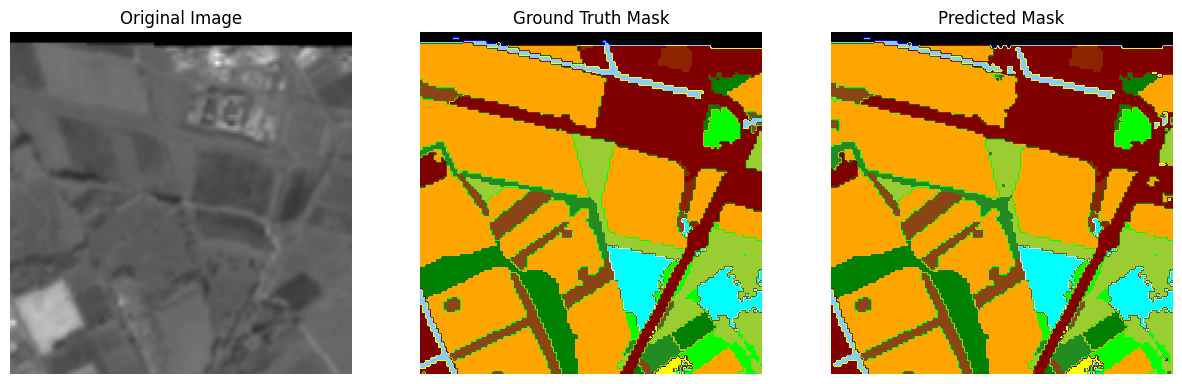

In [26]:
import torch
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


msi_dir = 'C:\\Users\\Zeynep\\Desktop\\DL\\_02_\\data\\C2Seg_AB_splitted\\C2Seg_AB_splitted\\test\\msi'
sar_dir = 'C:\\Users\\Zeynep\\Desktop\\DL\\_02_\\data\\C2Seg_AB_splitted\\C2Seg_AB_splitted\\test\\sar'
mask_dir = 'C:\\Users\\Zeynep\\Desktop\\DL\\_02_\\data\\C2Seg_AB_splitted\\C2Seg_AB_splitted\\test\\label'


combined_dataset = CombinedDataset(msi_dir, sar_dir, mask_dir)


image_tensor, label = combined_dataset[21]  # Python indexleri 0'dan başladığı için 22. görüntü index 21'dir


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('unet++-resnt50-CE-adam-lr1e3-bs16-2024-09-01.pt')
model.to(device)
model.eval()


image_tensor = image_tensor.to(device)


with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))  #[batch_size, channels, height, width]
    output = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# colormap
label_map = np.array([
    (0, 0, 0),          # 0 - Background (Black)
    (0, 0, 255),        # 1 - Surface water (Blue)
    (135, 206, 250),    # 2 - Street (Light Sky Blue)
    (255, 255, 0),      # 3 - Urban Fabric (Yellow)
    (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
    (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
    (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
    (255, 165, 0),      # 7 - Arable Land (Orange)
    (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
    (154, 205, 50),     # 9 - Pastures (Yellow Green)
    (34, 139, 34),      # 10 - Forests (Forest Green)
    (139, 69, 19),      # 11 - Shrub (Saddle Brown)
    (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
    (0, 255, 255),      # 13 - Inland wetlands (Cyan)
])

cmap = ListedColormap(label_map / 255.0)  # Normalize RGB values to [0, 1]


fig, ax = plt.subplots(1, 3, figsize=(15, 5))



ax[0].imshow(np.mean(image_tensor.cpu().numpy()[:4, :, :], axis=0), cmap='gray')
ax[0].set_title('Original Image')


ax[1].imshow(label.numpy(), cmap=cmap)
ax[1].set_title('Ground Truth Mask')


ax[2].imshow(output, cmap=cmap)
ax[2].set_title('Predicted Mask')

for a in ax:
    a.axis('off')

plt.show()
